In [313]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collecting data from different datasets

In [314]:
# Load Sleep data from the .xpt file and setting 'SEQN' as the index for easier referencing
sleep = pd.read_sas('P_SLQ.xpt').set_index('SEQN')

# Rename columns for better readability and understanding of the data
sleep = sleep.rename(columns={'SLQ300': 'Bedtime_weekdays',      # Usual sleep time on weekdays or workdays
                              'SLQ310': 'Wake_time_weekdays',    # Usual wake time on weekdays or workdays
                               'SLD012': 'Sleep_hrs_weekdays',    # Sleep hours - weekdays or workdays
                              'SLQ320': 'Bedtime_weekends',      # Usual bedtime on weekends
                              'SLQ330': 'Wake_time_weekends',    # Usual wake time on weekends
                              'SLD013': 'Sleep_hrs_weekends',    # Sleep hours - weekends
                              'SLQ040': 'Stop_breathing',        # How often do you snort or stop breathing
                              'SLQ030': 'Snore',                 # How often do you snore?
                              'SLQ050': 'Sleeping_problems',     # Ever told doctor had trouble sleeping?
                              'SLQ120': 'Sleepy_during_day'})    # How often feel overly sleepy during day?

# Convert columns with byte strings to normal strings.
time_cols = ['Bedtime_weekdays', 'Wake_time_weekdays', 'Bedtime_weekends', 'Wake_time_weekends'] #Columns with byte strings
for col in time_cols:
    sleep[col] = sleep[col].str.decode('utf-8')

# Replace '77777' and '99999' with NaN (because they represent 'refused' or 'don't know').
sleep[time_cols] = sleep[time_cols].replace({'77777': np.nan, '99999': np.nan, '': np.nan})

# Create columns with bedtime and wake-up time in hours (float) using datetime formatting for calculation
for col in time_cols:
    temp = pd.to_datetime(sleep[col], format='%H:%M', errors='coerce')
    sleep[f'{col}_hrs'] = temp.dt.hour +  temp.dt.minute / 60

# Drop missing values for Bedtime/Wake_time and Sleep_hrs 
# The analysis has shown that there is no overlap where we can recover (calculate) any missing values
critical_cols = ['Bedtime_weekdays_hrs', 'Wake_time_weekdays_hrs',
                 'Bedtime_weekends_hrs', 'Wake_time_weekends_hrs',
                 'Sleep_hrs_weekdays', 'Sleep_hrs_weekends'] 

# Drop rows with any missing values in critical columns
size_before = len(sleep)
sleep.dropna(subset=critical_cols, inplace=True)
print(f'Retained rows: {len(sleep) / size_before}')

# Create circular encoded time columns for correct distance calculations (for example, 23:00 and 1:00)
time_cols_hrs = [f'{col}_hrs' for col in time_cols]

for col in time_cols_hrs:
    sleep[f'{col}_sin'] = np.sin(2 * np.pi * sleep[col] / 24)
    sleep[f'{col}_cos'] = np.cos(2 * np.pi * sleep[col] / 24)

# Create column to calculate difference between weekday/weekend bedtimes
sleep['Social_Jetlag'] = np.sqrt(
    (sleep.Bedtime_weekends_hrs_sin - sleep.Bedtime_weekdays_hrs_sin) ** 2 + (sleep.Bedtime_weekends_hrs_cos - sleep.Bedtime_weekdays_hrs_cos) ** 2
)

# Convert 'Social_Jetlag' to hours for better interpretation
sleep['Jetlag_hrs'] = 2 * np.arcsin(sleep.Social_Jetlag / 2) * 24 /(2 * np.pi)
   
# Choose categorical columns
cat_cols = ['Stop_breathing', 'Snore', 'Sleeping_problems', 'Sleepy_during_day']

# Codes
# 'Stop_breathing': 0 - Never, 1 - Rarely (1-2 nights a week), 2 - Occasionally (3-4 nights a week), 
#                   3 - Frequently (5 or more nights a week), 7 - Refused, 9 - Don't know
# 'Snore': 0 - Never, 1 - Rarely (1-2 nights a week), 2 - Occasionally (3-4 nights a week), 
#          3 - Frequently (5 or more nights a week), 7 - Refused, 9 - Don't know
# 'Sleeping_problems': 1 - Yes, 2 - No, 7 - Refused, 9 - Don't know
# 'Sleepy_during_day': 0 - Never, 1 - Rarely (1 time a month), 2 - Sometimes (2-4 times a month),
#                      3 - Often (5-15 times a month), 4 - Almost always (16-30 times a month),
#                      7 - Refused, 9 - Don't know


# Replace very small nuber (5.397605e-79) with 0
# Replace '7' and '9' with NaN
for col in cat_cols:
    sleep[col] = sleep[col].apply(lambda x: 0 if isinstance(x, float) and abs(x - 5.397605e-79) < 1e-80 else x)
    sleep[col] = sleep[col].replace([7, 9], np.nan)

# Replace 2 which indicates 'No' by 0 in 'Sleeping_problem' column
sleep.Sleeping_problems = sleep.Sleeping_problems.replace(2, 0)

# Create indicators for missing values in categorical columns
# Impute missing values in categorical columns with mode
for col in cat_cols:
    sleep[f'{col}_missing'] = sleep[col].isnull().astype(int)
    sleep[col] = sleep[col].fillna(sleep[col].mode()[0])

# Sleep Apnea Risk score
sleep['Sleep_Apnea_risk'] = (sleep.Snore == 3).astype(int) + (sleep.Stop_breathing == 3).astype(int)

# Sleep Health Index score(higher -> better)
sleep['Sleep_health'] = (sleep.Sleep_hrs_weekdays + sleep.Sleep_hrs_weekends -
                              sleep.Jetlag_hrs - sleep.Sleeping_problems)

# Sleep Midpoint (circadian phase indicator)
sleep['Sleep_midpoint_weekdays'] = (sleep.Bedtime_weekdays_hrs + 0.5 * sleep.Sleep_hrs_weekdays) % 24
sleep['Sleep_midpoint_weekends'] = (sleep.Bedtime_weekends_hrs + 0.5 * sleep.Sleep_hrs_weekends) % 24

# Sleep Regularity metrics
sleep['Bedtime_SD'] = sleep[['Bedtime_weekdays_hrs_sin', 'Bedtime_weekends_hrs_sin']].std(axis=1)
sleep['Sleep_Duration_SD'] = sleep[['Sleep_hrs_weekdays', 'Sleep_hrs_weekends']].std(axis=1)

# Classify sleep schedule based on bedtime during weekdays (since it better reflects lifestyle).
# - 'Normal': 8 PM - 2 AM (common sleep schedule used as a baseline in studies).
# - 'Night Owl': 2 AM - 6 AM (late sleepers).
# - 'Day Sleeper': 6 AM - 12 PM (those sleeping in the morning, often shift workers).

sleep['Sleep_schedule'] = sleep.Bedtime_weekdays_hrs.apply(
    lambda x: 'Normal' if 20 <= x < 24 else 'Late Sleeper' if x <= 4 else 'Day Sleeper')

print(sleep.shape)

Retained rows: 0.9782246199117214
(9973, 35)


array([[<Axes: title={'center': 'Diabetes'}>]], dtype=object)

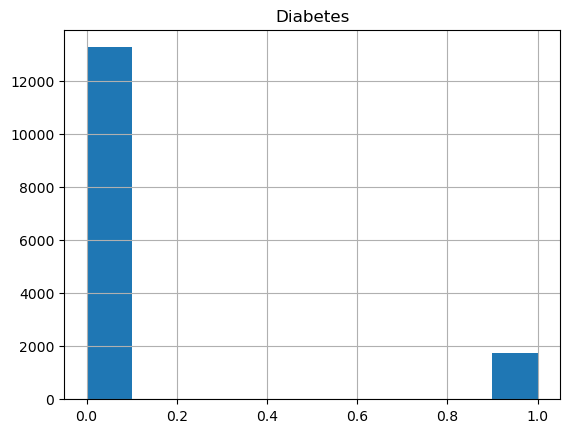

In [315]:
# Load Diabetes data from the .xpt file and setting 'SEQN' as the index for easier referencing
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing and renaming for better interpretability
diabetes = pd.read_sas('P_DIQ.xpt')[['SEQN','DIQ010']].set_index('SEQN').rename(columns={'DIQ010': 'Diabetes'})

# Codes
# 1	Yes		
# 2	No	
# 3	Borderline
# 7	Refused	
# 9	Don't know

diabetes.Diabetes = diabetes.Diabetes.replace({2: 0, 3: 1, 7: 0, 9: 0})

diabetes.hist()

In [377]:
diabetes.shape


(14986, 1)

In [316]:
# Choose columns to select from datasets
cols = ['SEQN', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665', 'PAD680']

# Adults (older than 18)
# SEQN - Respondent sequence number         
# PAQ605 - Vigorous work activity            Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ620 - Moderate work activity            Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ635 - Walk or bicycle                   Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ650 - Vigorous recreational activities  Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAQ665 - Moderate recreational activities  Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
# PAD680 - Minutes sedentary activity        Codes: 0 to 1320: Range of Values, 7777: Refused, 9999: Don't know ; 5.39760535e-79

# Load Physical activity data
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing
physical_activity = pd.read_sas('P_PAQ.xpt')[cols].set_index('SEQN')

# Choose columns with discrete values
binary_cols = ['PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665']
new_names = ['Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational']

# Replace coded values in these columns: 2-> 0, 7 -> np.nan, 9 -> np.nan
# Replace missing values with mode
for col in binary_cols:
    physical_activity[col] = physical_activity[col].replace({2: 0, 7: np.nan, 9: np.nan})
    mode_value = physical_activity[col].mode()[0]
    physical_activity[col] = physical_activity[col].fillna(mode_value)

# Rename these columns for better interpretability of the data
for old, new in zip(binary_cols, new_names):
    physical_activity.rename(columns={old: new}, inplace=True)

# Rename PAD680 column
physical_activity.rename(columns={'PAD680': 'Sedentary_mins'}, inplace=True)

# Replace very small value (5.39760535e-79) in sedentary activity column with np.nan, since 0 is not realistic
physical_activity.Sedentary_mins = physical_activity.Sedentary_mins.apply(
    lambda x: np.nan if isinstance(x, float) and abs(x - 5.39760535e-79) < 1e-80 else x)

# Winsorize the invalid entries for Sedentary minutes (should be less than 1440 (24 hours))
physical_activity.Sedentary_mins = np.clip(physical_activity.Sedentary_mins, 1, 1440)

# Replace missing values in sedentary activity column with mode
physical_activity.Sedentary_mins = physical_activity.Sedentary_mins.fillna(physical_activity.Sedentary_mins.mode()[0])


# Create composite activity score
physical_activity['Activity_score'] = (physical_activity.Vigorous_work * 3 +
                                       physical_activity.Moderate_work * 2 +
                                       physical_activity.Walk_or_bicycle * 1 +
                                       physical_activity.Vigorous_recreational * 3 +
                                       physical_activity.Moderate_recreational * 2)

# Create column to categorize activity level
physical_activity['Activity_category'] = pd.cut(physical_activity.Activity_score,
                                                bins=[-1, 4, 8, 12],
                                                labels=['Low', 'Moderate', 'High'])

# Convert sedentary minutes to hours
physical_activity['Sedentary_hrs'] = physical_activity.Sedentary_mins / 60

# Create column to categorize sedentary behavior
physical_activity['Sedentary_category'] = pd.cut(physical_activity.Sedentary_hrs,
                                                 bins=[-1, 4, 8, 12, np.inf],
                                                 labels=['Low', 'Moderate', 'High', 'Very High'])

# Create inverse sedentary score
physical_activity['Inverse_sedentary_score'] = 4 - physical_activity.Sedentary_category.cat.codes

# Combine activity and sedentary score
physical_activity['Lifestyle_score'] = physical_activity.Activity_score + physical_activity.Inverse_sedentary_score

# Create column to categorize lifestyle
physical_activity['Lifestyle_category'] = pd.cut(physical_activity.Lifestyle_score,
                                                 bins=[-1, 4, 8, 12, np.inf],
                                                 labels=['Sedentary', 'Low Active', 'Moderate Active', 'Highly Active'])


In [378]:
physical_activity.shape

(9693, 13)

In [317]:
# Load smoke data
# Selecting only relevant column and setting 'SEQN' as the index for easier referencing
# SEQN - Respondent sequence number
# SMQ020 - Smoked at least 100 cigarettes in life
# Codes: Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
smoke = pd.read_sas('P_SMQ.xpt')[['SEQN', 'SMQ020']].set_index('SEQN')

# Rename SMQ020 column for better understanding of data
smoke.rename(columns={'SMQ020': 'Smoked'}, inplace=True)

# Encode negative answer as 0, refused and don't know as nan
smoke.Smoked = smoke.Smoked.replace({2: 0, 7: np.nan, 9: np.nan})

# Replace missing values with mode (after merging with sleep and lifestyle datasets only 5 missing entries will be there)
smoke.Smoked = smoke.Smoked.fillna(smoke.Smoked.mode()[0])


In [379]:
smoke.shape

(11137, 1)

In [318]:
# Load medical conditions data (family history of diabetes)
# Selecting only relevant column and setting 'SEQN' as the index for easier referencing
# SEQN - Respondent sequence number
# MCQ300C - Close relative had diabetes?
# MCQ220 - Ever told you had cancer or malignancy?
# Codes: Codes: 1: Yes, 2: No, 7: Refused, 9: Don't know
diabetes_hist = pd.read_sas('P_MCQ.xpt')[['SEQN', 'MCQ300C', 'MCQ220']].set_index('SEQN')

# Rename the column for better interpretability and understanding of data
diabetes_hist.rename(columns={'MCQ300C': 'Diabetes_family_history_coded'}, inplace=True)
diabetes_hist.rename(columns={'MCQ220': 'Cancer_coded'}, inplace=True)

# Replace 2 (No) with 0
diabetes_hist['Diabetes_family_history_coded'] = diabetes_hist.Diabetes_family_history_coded.replace({2: 0})
diabetes_hist['Cancer_coded'] = diabetes_hist.Cancer_coded.replace({2: 0})

# Replace 'Refused' (7), 'Don't know' (9), and missing values with 2 (Unknown)
diabetes_hist['Diabetes_family_history_coded'] = diabetes_hist.Diabetes_family_history_coded.replace({7: 2, 9: 2}).fillna(2)
diabetes_hist['Cancer_coded'] = diabetes_hist.Cancer_coded.replace({7: 2, 9: 2}).fillna(2)

# Map the values to meaningful labels for clarity
diabetes_hist['Diabetes_family_history'] = diabetes_hist['Diabetes_family_history_coded'].map({
    0: 'No',
    1: 'Yes',
    2: 'Unknown'
})
diabetes_hist['Cancer'] = diabetes_hist['Cancer_coded'].map({
    0: 'No',
    1: 'Yes',
    2: 'Unknown'
})


In [380]:
diabetes_hist.shape

(14986, 4)

### Merge sleep dataset with physical activity, smoked status and diabetes family history data

In [319]:
# Merge sleep with physical activity data
sleep_lifestyle_diabetes = sleep.merge(physical_activity, left_index=True, right_index=True)

# Merge with smoke dataset
sleep_lifestyle_diabetes = sleep_lifestyle_diabetes.merge(smoke, left_index=True, right_index=True)

# Merge with diabetes dataset
sleep_lifestyle_diabetes = sleep_lifestyle_diabetes.merge(diabetes, left_index=True, right_index=True)

# Merge with diabetes family history dataset
sleep_lifestyle_diabetes = sleep_lifestyle_diabetes.merge(diabetes_hist, left_index=True, right_index=True)

print('Shape of merged dataset:', sleep_lifestyle_diabetes.shape)
print('Missing values of merged dataset: ',sleep_lifestyle_diabetes.isnull().sum().sum())
print('Columns after merging:', sleep_lifestyle_diabetes.columns.tolist())

Shape of merged dataset: (9480, 54)
Missing values of merged dataset:  0
Columns after merging: ['Bedtime_weekdays', 'Wake_time_weekdays', 'Sleep_hrs_weekdays', 'Bedtime_weekends', 'Wake_time_weekends', 'Sleep_hrs_weekends', 'Snore', 'Stop_breathing', 'Sleeping_problems', 'Sleepy_during_day', 'Bedtime_weekdays_hrs', 'Wake_time_weekdays_hrs', 'Bedtime_weekends_hrs', 'Wake_time_weekends_hrs', 'Bedtime_weekdays_hrs_sin', 'Bedtime_weekdays_hrs_cos', 'Wake_time_weekdays_hrs_sin', 'Wake_time_weekdays_hrs_cos', 'Bedtime_weekends_hrs_sin', 'Bedtime_weekends_hrs_cos', 'Wake_time_weekends_hrs_sin', 'Wake_time_weekends_hrs_cos', 'Social_Jetlag', 'Jetlag_hrs', 'Stop_breathing_missing', 'Snore_missing', 'Sleeping_problems_missing', 'Sleepy_during_day_missing', 'Sleep_Apnea_risk', 'Sleep_health', 'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends', 'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_schedule', 'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreationa

In [320]:
# Load Demographic data from the .xpt file
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing
demographic = pd.read_sas('P_DEMO.xpt')[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'INDFMPIR']].set_index('SEQN')

# Rename columns for better readability and understanding of the data
demographic.rename(columns={'RIAGENDR': 'Gender',                # Gender
                            'RIDAGEYR': 'Age',                   # Age in years at screening
                            'INDFMPIR': 'Poverty_index',         # Ratio of family income to poverty
                            'RIDRETH3': 'Race'}, inplace=True)   # Race/Hispanic origin w/ NH Asian

# Coded values
# 'Gender': 1 - Male, 2 - Female
# 'Race': 1	- Mexican American,	2 -	Other Hispanic,	3 -	Non-Hispanic White,	4 -	Non-Hispanic Black,	
#         6 - Non-Hispanic Asian, 7 - Other Race (Including Multi-Racial)
# 'Poverty_index: 0 to 4.98	Range of Values	
#                 5	Value greater than or equal to 5.00	

# Replace coded values in Gender column for beter understanding data
demographic.Gender = demographic.Gender.replace({2: 0})

print('Shape of demographic dataset:', demographic.shape)
print('Missing values of demographic dataset: ',demographic.isnull().sum().sum())

Shape of demographic dataset: (15560, 4)
Missing values of demographic dataset:  2201


In [321]:
# Load BMI data from the .xpt file
# Selecting only relevant columns and setting 'SEQN' as the index for easier referencing
# BMXWAIST - Waist Circumference (cm)
bmi = pd.read_sas('P_BMX.xpt')[['SEQN', 'BMXBMI', 'BMXWAIST']].set_index('SEQN') 

# Rename columns for better readability and understanding of the data
bmi.rename(columns={'BMXBMI': 'BMI', 'BMXWAIST': 'Waist_cm'}, inplace=True)                    # Body Mass Index (kg/m**2)

print('Shape of bmi dataset:', bmi.shape)
print('Missing values of bmi dataset: \n',bmi.isnull().sum())

Shape of bmi dataset: (14300, 2)
Missing values of bmi dataset: 
 BMI         1163
Waist_cm    1726
dtype: int64


Number of entries out of the biologically plausible range ( BMI < 15 and BMI > 50):  175


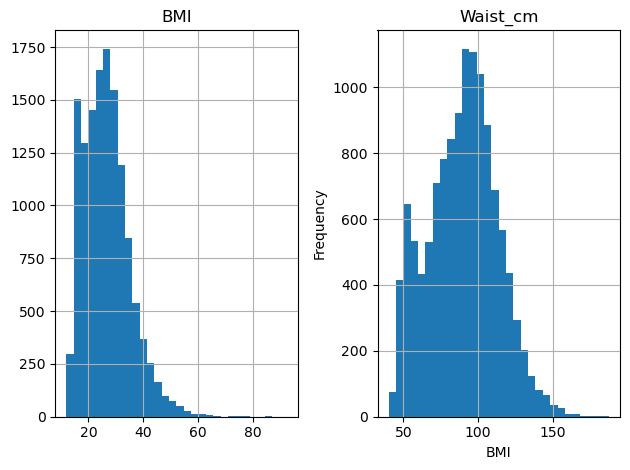

In [322]:
print('Number of entries out of the biologically plausible range ( BMI < 15 and BMI > 50): ', ((bmi.BMI < 12) | (bmi.BMI > 50)).sum())

# Plot distribution before Winsorization
bmi.hist(bins=30)
#plt.title('BMI before Winsorization')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()

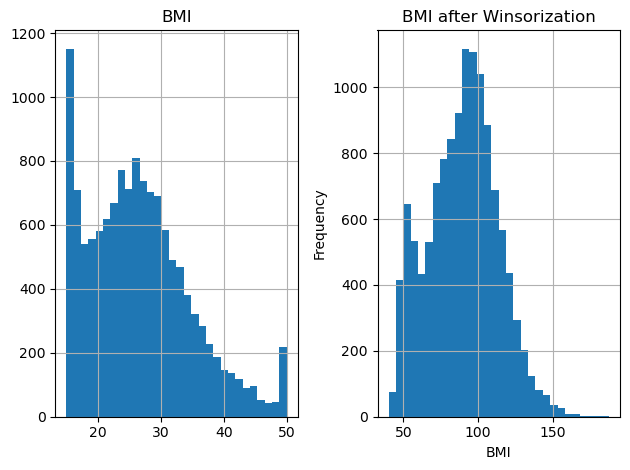

In [198]:
# Winsorize BMI within biologically plausible range ( BMI > 15 and BMI < 50)
bmi.BMI = np.clip(bmi.BMI, 15, 50)

# Plot distribution after Winsorization
bmi.hist(bins=30)
plt.title('BMI after Winsorization')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()

In [323]:
# Load Blood Pressure data from the .xpt file and setting 'SEQN' as the index for easier referencing
b_p = pd.read_sas('P_BPXO.xpt').set_index('SEQN')

# Choose columns with Systolic Blood Pressure measurements (mm Hg)
# 'BPXOSY1', 'BPXOSY2', 'BPXOSY3' - columns with Systolic Blood Pressure measurements (1st, 2nd and 3rd readings respectively)
bp_cols_sys = ['BPXOSY1', 'BPXOSY2', 'BPXOSY3'] 

# Choose columns with Diastolic Blood Pressure measurements (mm Hg)
# 'BPXODI1', 'BPXODI2', 'BPXODI3' - columns with Diastolic Blood Pressure measurements (1st, 2nd and 3rd readings respectively)
bp_cols_dia = ['BPXODI1', 'BPXODI2', 'BPXODI3']

# Create a column with the average Systolic Blood Pressure
b_p['BP_Systolic'] = b_p[bp_cols_sys].mean(axis=1, skipna=True)

# Create a column with the average Diastolic Blood Pressure
b_p['BP_Diastolic'] = b_p[bp_cols_dia].mean(axis=1, skipna=True)

# Choose the columns with the average Blood Pressure measurements for further analysis
blood_pressure = b_p[['BP_Systolic', 'BP_Diastolic']]

print('Shape of blood pressure dataset:', blood_pressure.shape)
print('Missing values of blood pressure dataset: \n',blood_pressure.isnull().sum())

Shape of blood pressure dataset: (11656, 2)
Missing values of blood pressure dataset: 
 BP_Systolic     1303
BP_Diastolic    1303
dtype: int64


In [324]:
# Lipoprotein

# Load High-Density Lipoprotein data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
HDL = pd.read_sas('P_HDL.xpt').set_index('SEQN')

# Choose the column 'LBDHDD': Direct HDL-Cholesterol (mg/dL)                                          missing values: 1370
# Rename 'LBDHDD' column for better readability and understanding of the data                         shape: (12198, 1)
HDL = HDL[['LBDHDD']].rename(columns={'LBDHDD': 'HDL'})

# Load Low-Density Lipoprotein data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
LDL = pd.read_sas('P_TRIGLY.xpt').set_index('SEQN')

# Choose the necessary coumns:                                                                         missing values:
# 'LBXTR' - Triglycerides (mg/dL) and 'LBDLDL' - LDL-Cholesterol, Friedewald (mg/dL)                   LDL             473        
# and rename them for better readability and understanding of the data                                 Triglycerides    440
LDL = LDL[['LBXTR', 'LBDLDL']].rename(columns={'LBXTR': 'Triglycerides', 'LBDLDL': 'LDL'})            # shape: (5090, 2)


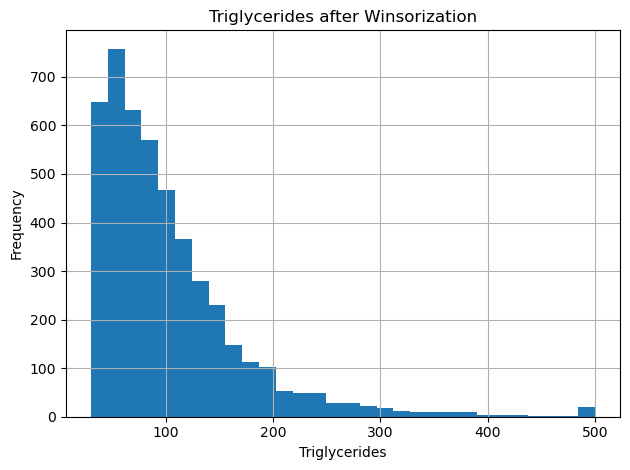

In [325]:
# Winsorize Triglycerides within biologically plausible range (between 30 and 500)
LDL.Triglycerides = np.clip(LDL.Triglycerides, 30, 500)

# Plot distribution after Winsorization
LDL.Triglycerides.hist(bins=30)
plt.title('Triglycerides after Winsorization')
plt.xlabel('Triglycerides')
plt.ylabel('Frequency')
plt.tight_layout()

Statistics:

       Fasting_glucose      Insulin
count      4744.000000  4625.000000
mean        111.182125    14.975684
std          36.314648    22.845041
min          47.000000     0.710000
25%          95.000000     6.310000
50%         102.000000    10.180000
75%         112.000000    16.610000
max         524.000000   512.500000
               GHB
count  9737.000000
mean      5.765575
std       1.066217
min       2.800000
25%       5.200000
50%       5.500000
75%       5.900000
max      16.200000


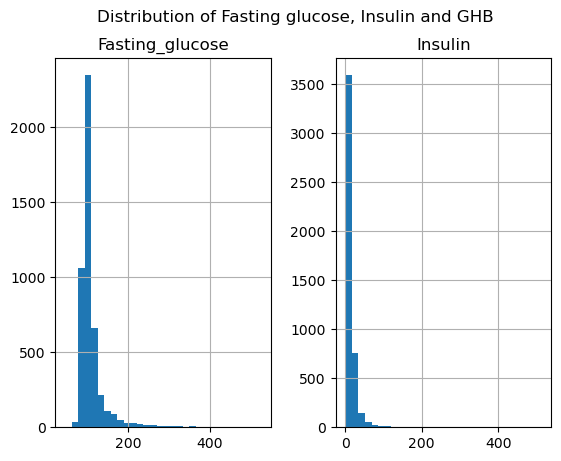

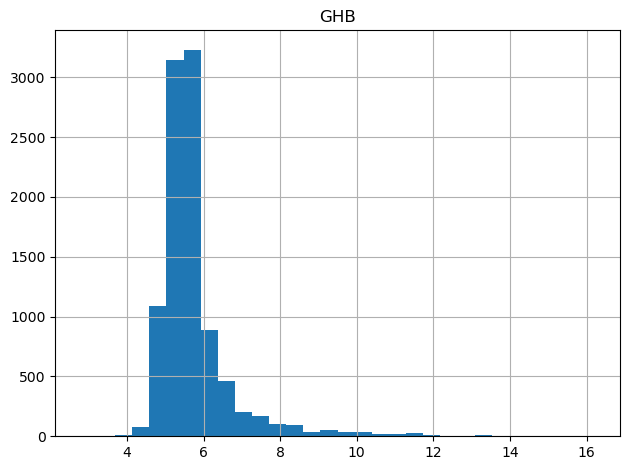

In [359]:
# GLUCOSE METABOLISM AND DIABETES RISK

# Load Glycohemoglobin data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
GHB = pd.read_sas('P_GHB.xpt').set_index('SEQN')

# Rename 'LBXGH' column (Glycohemoglobin (%)) for better readability and understanding of the dataLBXGH 
GHB.rename(columns={'LBXGH': 'GHB'}, inplace=True)


# Load Fasting Glucose data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
fasting_glucose = pd.read_sas('P_GLU.xpt').set_index('SEQN')

# Choose the column 'LBXGLU' - Fasting Glucose (mg/dL)
# Rename 'LBXTC' column for better readability and understanding of the data
fasting_glucose = fasting_glucose[['LBXGLU']].rename(columns={'LBXGLU':'Fasting_glucose'})    #(5090, 1)


# Load Insulin data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
insulin = pd.read_sas('P_INS.xpt').set_index('SEQN')

# Choose the column 'LBXIN' - Insulin (μU/mL)
# Rename 'LBXIN' column for better readability and understanding of the data
insulin = insulin[['LBXIN']].rename(columns={'LBXIN': 'Insulin'})                               #(5090, 1)

# Create separate DataFrame for analyzing metabolism and diabetes risk 
sugar = fasting_glucose.merge(insulin, left_index=True, right_index=True)

# Statistics for Fasting glucose , Insulin and GHB
print('Statistics:\n')
print(sugar.describe())
print(GHB.describe())

# Plot histogram of Fasting glucose and Insulin
sugar.hist(bins=30)
plt.suptitle('Distribution of Fasting glucose, Insulin and GHB')

# Plot histogram of GHB
GHB.hist(bins=30)

plt.tight_layout()

Extreme outliers:

Fasting Glucose (values below 50  and above 300)

Insulin (values below 1  and above 100)

GHB (values below 3 and above 12)

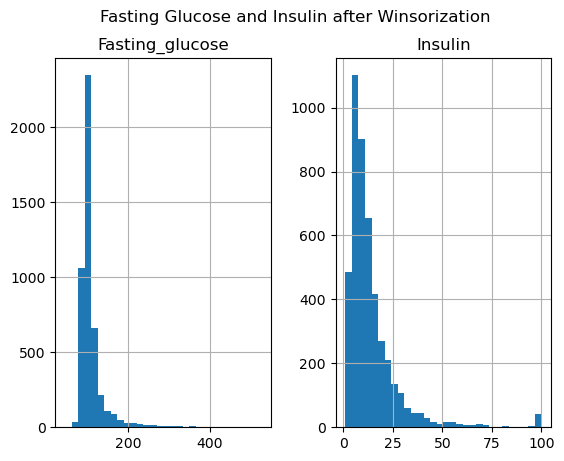

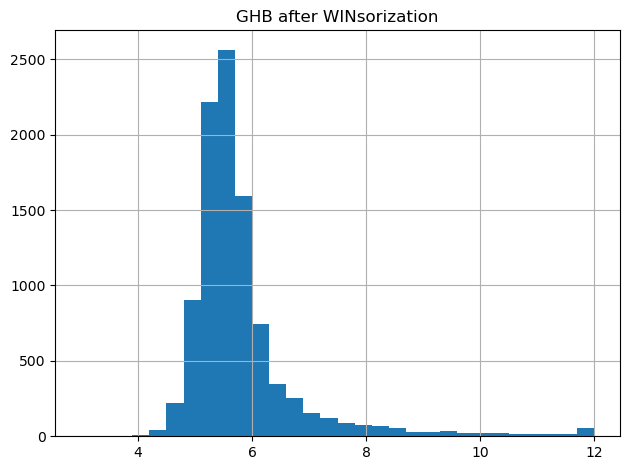

In [360]:
# Winsorize Fasting Glucose, Insulin and GHB
#sugar.Fasting_glucose = np.clip(sugar.Fasting_glucose, 50, 300)
sugar.Insulin = np.clip(sugar.Insulin, 1, 100)
GHB.GHB = np.clip(GHB.GHB, 3, 12)

# Plot distribution after Winsorization
sugar.hist(bins=30)
plt.suptitle('Fasting Glucose and Insulin after Winsorization')


GHB.hist(bins=30)
plt.title('GHB after WINsorization')

plt.tight_layout()

In [334]:
# INFLAMMATION 

# Load High-Sensitivity C-Reactive Protein data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
CRP = pd.read_sas('P_HSCRP.xpt').set_index('SEQN')

# Choose the column 'LBXHSCRP' - HS C-Reactive Protein (mg/L)
# Rename 'LBXHSCRP' column for better readability and understanding of the data
CRP = CRP[['LBXHSCRP']].rename(columns={'LBXHSCRP': 'CRP'})


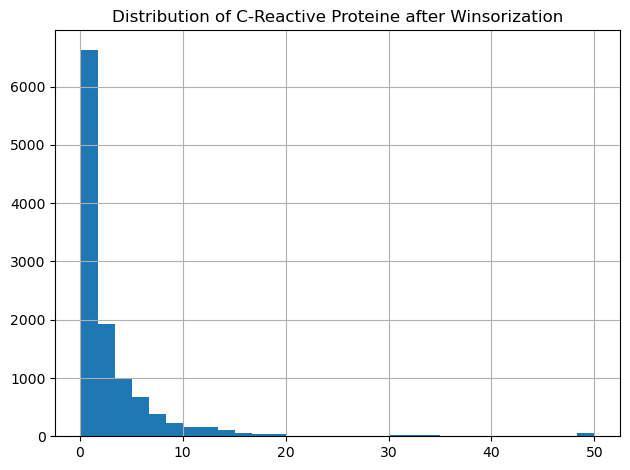

In [335]:
# Replace values below 0.1 with 0.1 and values above 50 with 50
CRP.CRP = np.clip(CRP.CRP, 0.1, 50)

# Check the distribution after winsorization
CRP.hist(bins=30)
plt.title('Distribution of C-Reactive Proteine after Winsorization')

plt.tight_layout()

In [92]:
# STANDARD BIOCHEMISTRY PROFILE

# Load Standard Biochemistry Profile data from the .xpt file
# Setting 'SEQN' as the index for easier referencing
bio_pro = pd.read_sas('P_BIOPRO.xpt').set_index('SEQN')

# Choose columns that can be useful in analyzing circadian rhythms and metabolism
# Liver enzymes: 'LBXSATSI' - Alanine Aminotransferase (ALT) (U/L),
#                'LBXSASSI' - Aspartate Aminotransferase (AST) (U/L),
#                'LBXSGTSI' - Gamma Glutamyl Transferase (GGT) (IU/L),
# 'LBXSUA' - Uric acid (mg/dL),
# 'LBXSCR' - Creatinine, refrigerated serum (mg/dL)
# 'LBXSAL' - Albumin, refrigerated serum (g/dL)
# 'LBXSBU' - Blood Urea Nitrogen (mg/dL)
# 'LBXSLDSI' - Lactate Dehydrogenase (LDH) (IU/L)
# 'LBXSGB' - Globulin (g/dL)
# 'LBXSTP' - Total Protein (g/dL)
# 'LBXSCH' - Cholesterol, refrigerated serum (mg/dL)

# renaming them for better readability and understanding of the data
cols = ['LBXSATSI', 'LBXSASSI', 'LBXSGTSI', 'LBXSUA', 'LBXSCR', 'LBXSTB', 'LBXSAL', 'LBXSBU', 'LBXSLDSI', 'LBXSGB', 'LBXSTP', 'LBXSCH']
bio_pro = bio_pro[cols].rename(columns={
    'LBXSATSI': 'ALT',
    'LBXSASSI': 'AST',
    'LBXSGTSI': 'GGT',
    'LBXSUA': 'Uric_acid',
    'LBXSCR': 'Creatinine',
    'LBXSTB': 'Bilirubin',
    'LBXSAL': 'Albumin',
    'LBXSBU': 'BUN',
    'LBXSLDSI': 'LDH',
    'LBXSGB': 'Globulin',
    'LBXSTP': 'Total_protein',
    'LBXSCH': 'Cholesterol'
    })
bio_pro.columns

Index(['ALT', 'AST', 'GGT', 'Uric_acid', 'Creatinine', 'Bilirubin', 'Albumin',
       'BUN', 'LDH', 'Globulin', 'Total_protein', 'Cholesterol'],
      dtype='object')

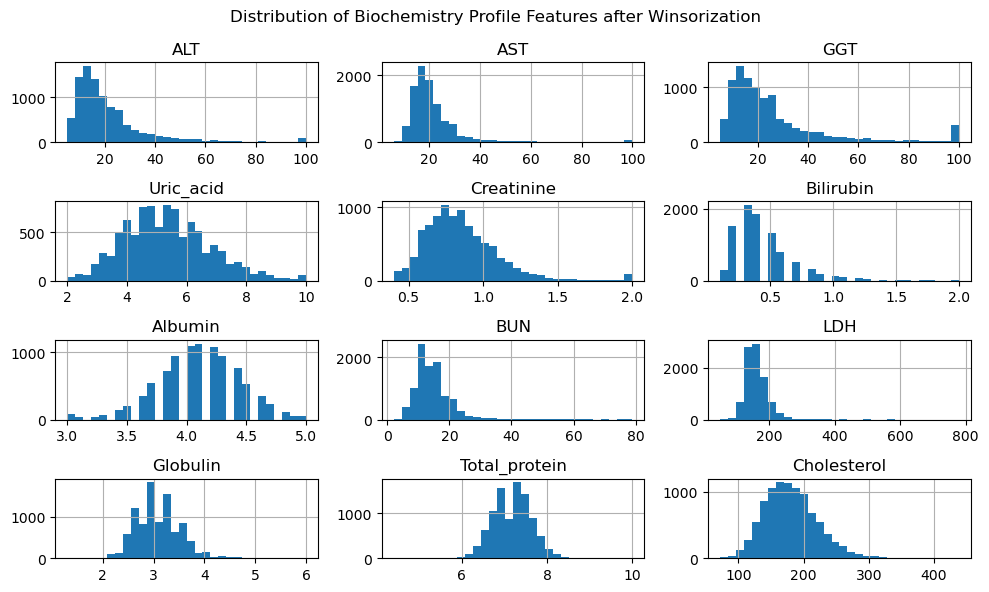

In [336]:
# Winsorize standard biochemistry profile features to reduce outliers and stabilize model,
# staying within the range of biological plausibility and without distorting data
bio_pro.ALT = np.clip(bio_pro.ALT, 5, 100)
bio_pro.AST = np.clip(bio_pro.AST, 5, 100)
bio_pro.GGT = np.clip(bio_pro.GGT, 5, 100)
bio_pro.Uric_acid = np.clip(bio_pro.Uric_acid, 2, 10)
bio_pro.Creatinine = np.clip(bio_pro.Creatinine, 0.4, 2)
bio_pro.Bilirubin = np.clip(bio_pro.Bilirubin, 0.1, 2)
bio_pro.Albumin = np.clip(bio_pro.Albumin, 3, 5)

# Check the distribution after winsorization
bio_pro.hist(bins=30, figsize=(10,6))

plt.suptitle('Distribution of Biochemistry Profile Features after Winsorization')
plt.tight_layout()

In [337]:
# HORMONES

# Load Hormones profile from .xpt file
# Setting 'SEQN' as the index for easier referencing
hormones = pd.read_sas('P_TST.xpt').set_index('SEQN')

# Hormones like SHBG and estradiol directly modulate insulin sensitivity and fat storage
# 'LBXSHBG' - SHBG (nmol/L) : Binds sex hormones (testosterone/estrogen); low SHBG -> insulin resistance, obesity
# 'LBXEST' - Estradiol (pg/mL) : Estrogen regulates fat distribution, glucose metabolism, and inflammation
# 'LBXAND' - Androstenedione (ng/dL) : Precursor to testosterone; elevated levels -> visceral fat, metabolic syndrome
# 'LBX17H' - 17α-hydroxyprogesterone (ng/dL) : Linked to adrenal function; dysregulation -> cortisol/metabolic disturbances
# 'LBXLUH' - Luteinizing Hormone (mIU/mL) : Regulate sex hormones; imbalances -> PCOS (strongly tied to insulin resistance)
# 'LBXFSH' - Follicle Stimulating Hormone (mIU/mL)


# Choose columns that can be useful in analyzing circadian rhythms and metabolism
cols = ['LBXSHBG', 'LBXEST', 'LBXAND', 'LBXLUH', 'LBXFSH']
hormones = hormones[cols]

# Rename them for better readability and understanding of the data
cols_new = ['SHBG', 'Estradiol', 'Androstenedione', 'Luteinizing_hormone', 'Follicle_stimulating_hormone']

for old, new in zip(cols, cols_new):
    hormones.rename(columns={old: new}, inplace=True)


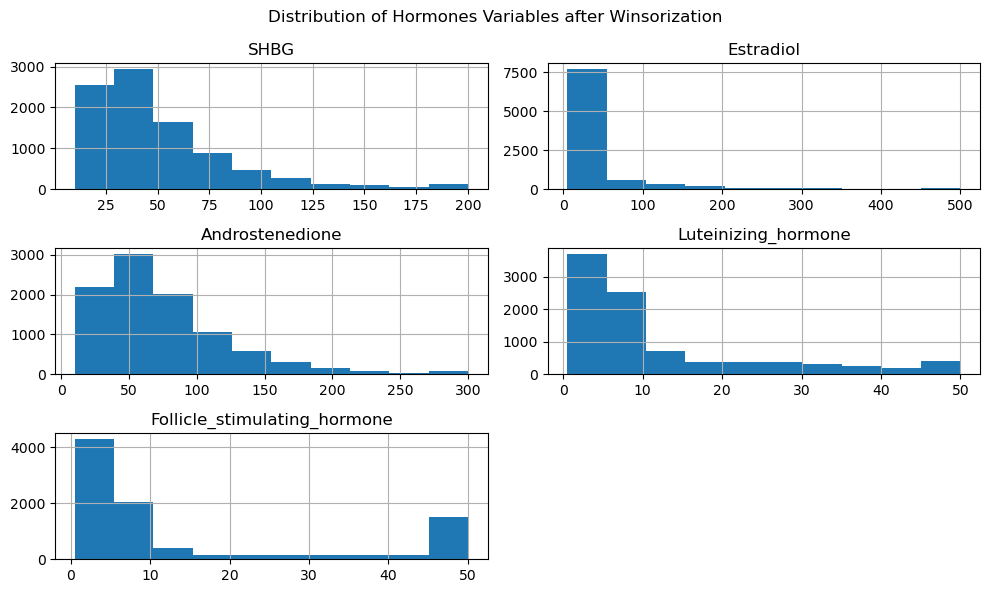

In [338]:
# Winsorize standard hormones profile features to reduce outliers and stabilize model,
# staying within the range of biological plausibility and without distorting data
hormones.SHBG = np.clip(hormones.SHBG, 10, 200)
hormones.Estradiol = np.clip(hormones.Estradiol, 5, 500)
hormones.Androstenedione = np.clip(hormones.Androstenedione, 10, 300)
hormones.Luteinizing_hormone = np.clip(hormones.Luteinizing_hormone, 0.5, 50)
hormones.Follicle_stimulating_hormone = np.clip(hormones.Follicle_stimulating_hormone, 0.5, 50)

# Check the distribution after winsorization
hormones.hist(figsize=(10,6))
plt.suptitle('Distribution of Hormones Variables after Winsorization')

plt.tight_layout()

In [339]:
# Dietary Factors

# Choose nesessary features
# DR1TKCAL - Energy (kcal)
# DR1TPROT - Protein (gm)
# DR1TCARB - Carbohydrate (gm)
# DR1TSUGR - Total sugars (gm)
# DR1TFIBE - Dietary fiber (gm)
# DR1TTFAT - Total fat (gm)
# DR1TSFAT - Total saturated fatty acids (gm)
# DR1TSODI - Sodium (mg)
# DR1TPOTA - Potassium (mg)
# DR1TCAFF - Caffeine (mg)
# DR1TALCO - Alcohol (gm)
# DR1DAY - Intake day of the week (could be relevant for circadian rhythm analysis)
# DRQSDIET - On special diet?
# DRQSDT1 to DRQSDT12 - Various types of diets (especially DRQSDT7 - Diabetic diet)

# DR1TMFAT - Total monounsaturated fatty acids (gm)
# DR1TPFAT - Total polyunsaturated fatty acids (gm)

'''
DRQSDIET - On special diet?
DRQSDT1 - Weight loss/Low calorie diet
DRQSDT2 - Low fat/Low cholesterol diet
DRQSDT3 - Low salt/Low sodium diet
DRQSDT4 - Sugar free/Low sugar diet
DRQSDT7 - Diabetic diet
DRQSDT9 - Low carbohydrate diet
DRQSDT10 - High protein diet

DR1TATOC - Vitamin E as alpha-tocopherol (mg)
DR1TVARA - Vitamin A, RAE (mcg)
DR1TVC - Vitamin C (mg)
DR1TVD - Vitamin D (D2 + D3) (mcg)
DR1TCALC - Calcium (mg)
DR1TIRON - Iron (mg)
DR1TZINC - Zinc (mg)
DR1TSELE - Selenium (mcg)

DR1TVB1 - Thiamin (Vitamin B1) (mg)
DR1TVB2 - Riboflavin (Vitamin B2) (mg)
DR1TNIAC - Niacin (mg)
DR1TVB6 - Vitamin B6 (mg)
DR1TFOLA - Total folate (mcg)
DR1TVB12 - Vitamin B12 (mcg)

DR1TACAR - Alpha-carotene (mcg)
DR1TBCAR - Beta-carotene (mcg)
DR1TLYCO - Lycopene (mcg)
DR1TLZ - Lutein + zeaxanthin (mcg)
'''

# Load Total Nutrient Intake (Day 1) from .xpt file
# Setting 'SEQN' as the index for easier referencing
nutrients_1 = pd.read_sas('P_DR1TOT.xpt').set_index('SEQN')

# Choose columns that can be useful in analyzing circadian rhythms and metabolism
# renaming them for better readability and understanding of the data
cols_1 = [
    'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT',
    'DR1TSFAT', 'DR1TSODI', 'DR1TPOTA', 'DR1TCAFF', 'DR1TALCO',
    'DR1TMFAT', 'DR1TPFAT',
    'DR1TATOC', 'DR1TVARA', 'DR1TVC', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TZINC', 'DR1TSELE',
    'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 'DR1TVB12',
    'DR1TACAR', 'DR1TBCAR', 'DR1TLYCO', 'DR1TLZ',
    'DRQSDIET', 'DRQSDT1', 'DRQSDT2', 'DRQSDT3', 'DRQSDT4', 'DRQSDT7', 'DRQSDT9', 'DRQSDT10']

# New names for the columns
cols_1_new = [
    'Energy_1', 'Protein_1', 'Carbohydrate_1', 'Total_sugars_1', 'Dietary_fiber_1', 'Total_fat_1',
    'Total_saturated_fatty_acids_1', 'Sodium_1', 'Potassium_1', 'Caffeine_1', 'Alcohol_1',
    'Total_monounsaturated_fatty_acids_1', 'Total_polyunsaturated_fatty_acids_1',
    'Vitamin_E_1', 'Vitamin_A_1', 'Vitamin_C_1', 'Vitamin_D_1', 'Calcium_1', 'Iron_1', 'Zinc_1', 'Selenium_1',
    'B1_1', 'B2_1', 'Niacin_1', 'B6_1', 'Total_folate_1', 'B12_1',
    'Alpha_carotene_1', 'Beta_carotene_1', 'Lycopene_1', 'Lutein_zeaxanthin_1',
    'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet', 'Low_carbohydrate_diet', 'High_protein_diet',
    
]

nutrients_1 = nutrients_1[cols_1].rename(columns=dict(zip(cols_1, cols_1_new)))

# Load Total Nutrient Intake (Day 2) from .xpt file
# Setting 'SEQN' as the index for easier referencing
nutrients_2 = pd.read_sas('P_DR2TOT.xpt').set_index('SEQN')

# Choose columns that can be useful in analyzing circadian rhythms and metabolism
# renaming them for better readability and understanding of the data
cols_2 = [
    'DR2TKCAL', 'DR2TPROT', 'DR2TCARB', 'DR2TSUGR', 'DR2TFIBE', 'DR2TTFAT',
    'DR2TSFAT', 'DR2TSODI', 'DR2TPOTA', 'DR2TCAFF', 'DR2TALCO', 'DR2TMFAT', 'DR2TPFAT',
    'DR2TATOC', 'DR2TVARA', 'DR2TVC', 'DR2TVD', 'DR2TCALC', 'DR2TIRON', 'DR2TZINC', 'DR2TSELE',
    'DR2TVB1', 'DR2TVB2', 'DR2TNIAC', 'DR2TVB6', 'DR2TFOLA', 'DR2TVB12',
    'DR2TACAR', 'DR2TBCAR', 'DR2TLYCO', 'DR2TLZ',
]

# New names for the columns
cols_2_new = [
    'Energy_2', 'Protein_2', 'Carbohydrate_2', 'Total_sugars_2', 'Dietary_fiber_2', 'Total_fat_2',
    'Total_saturated_fatty_acids_2', 'Sodium_2', 'Potassium_2', 'Caffeine_2', 'Alcohol_2',
    'Total_monounsaturated_fatty_acids_2', 'Total_polyunsaturated_fatty_acids_2',
    'Vitamin_E_2', 'Vitamin_A_2', 'Vitamin_C_2', 'Vitamin_D_2', 'Calcium_2', 'Iron_2', 'Zinc_2', 'Selenium_2',
    'B1_2', 'B2_2', 'Niacin_2', 'B6_2', 'Total_folate_2', 'B12_2',
    'Alpha_carotene_2', 'Beta_carotene_2', 'Lycopene_2', 'Lutein_zeaxanthin_2',
]

nutrients_2 = nutrients_2[cols_2].rename(columns=dict(zip(cols_2, cols_2_new)))

# Merge both Day 1 and Day 2 datasets
nutrients = nutrients_1.merge(nutrients_2, left_index=True, right_index=True)
nutrients.columns

# Replace very small nuber (5.39760535e-79) with 0 
cols_replace = ['Caffeine_1', 'Caffeine_2', 'Alcohol_1','Alcohol_2']
for col in cols_replace:
    nutrients[col] = nutrients[col].apply(lambda x: 0 if isinstance(x, float) and abs(x - 5.39760535e-79) < 1e-80 else x)

# Create columns average of Day 1 and Day 2
cols_avg = [
    'Energy', 'Protein', 'Carbohydrate', 'Total_sugars', 'Dietary_fiber', 'Total_fat',
    'Total_saturated_fatty_acids', 'Sodium', 'Potassium', 'Caffeine', 'Alcohol',
    'Total_monounsaturated_fatty_acids', 'Total_polyunsaturated_fatty_acids',
    'Vitamin_E', 'Vitamin_A', 'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc', 'Selenium',
    'B1', 'B2', 'Niacin', 'B6', 'Total_folate', 'B12',
    'Alpha_carotene', 'Beta_carotene', 'Lycopene', 'Lutein_zeaxanthin',
]

# Calculate the average for each pair of variables from Day 1 and Day 2
# If one of the entries is nan, choose non-nan entry as average 
for col in cols_avg:
    nutrients[col] = nutrients[[f'{col}_1', f'{col}_2']].mean(skipna=True, axis=1)
    
    # Drop columns from Day 1 and Day 2 observations, leaving the average
    nutrients.drop([f'{col}_1', f'{col}_2'], axis=1, inplace=True)

# Fill missing values with 0 for diet columns
diets = ['Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet', 'Low_carbohydrate_diet', 'High_protein_diet']
nutrients[diets] = nutrients[diets].fillna(0)

# Replace encoded entries
nutrients.Diet = nutrients.Diet.replace({2: 0, 9: 0})
nutrients[diets] = nutrients[diets].replace({2: 1, 3: 1, 4: 1, 7: 1, 9: 1, 10: 1})


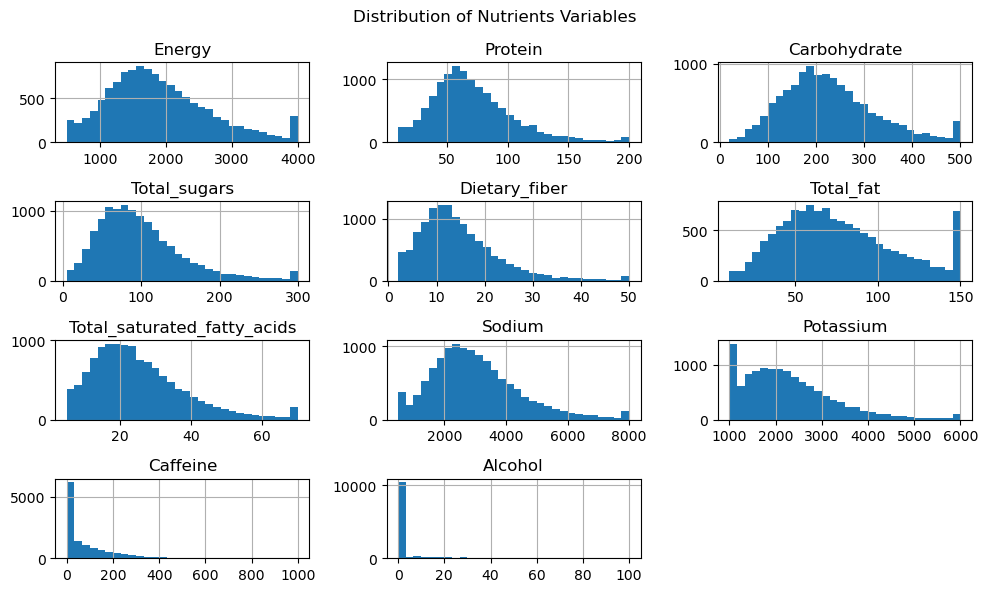

In [340]:
# Winsorize standard hormones profile features to reduce outliers and stabilize model,
# staying within the range of biological plausibility and without distorting data
plausible_ranges = {
    'Energy': [500, 4000],
    'Protein': [10, 200],
    'Carbohydrate': [20, 500],
    'Total_sugars': [5, 300],
    'Dietary_fiber': [2, 50],
    'Total_fat': [10, 150],
    'Total_saturated_fatty_acids': [5, 70],
    'Sodium': [500, 8000],
    'Potassium': [1000, 6000],
    'Caffeine': [0, 1000],
    'Alcohol': [0, 100]}

for var in plausible_ranges.keys():
    nutrients[var] = np.clip(nutrients[var], plausible_ranges[var][0], plausible_ranges[var][1])

winsorised = [var for var in plausible_ranges.keys()]

# Check the distribution after winsorization
nutrients[winsorised].hist(bins=30, figsize=(10,6))
plt.suptitle('Distribution of Nutrients Variables')

plt.tight_layout()

### Merging datasets

In [361]:
# Merge all datasets with large amount of entries (around 10 000)

# Merge demographic data with hormones dataset
large_data = demographic.merge(hormones, left_index=True, right_index=True)

# Merge bmi dataset with merged dataset
large_data = large_data.merge(bmi, left_index=True, right_index=True)

# Merge blood pressure dataset with the merged data
large_data = large_data.merge(blood_pressure, left_index=True, right_index=True)

# Merge HDL dataset with the merged data
large_data = large_data.merge(HDL, left_index=True, right_index=True)

# Merge GHB dataset with the merged data
large_data = large_data.merge(GHB, left_index=True, right_index=True)

# Merge CRP dataset with the merged data
large_data = large_data.merge(CRP, left_index=True, right_index=True)

# Merge biochemistry profle dataset with the merged data
large_data = large_data.merge(bio_pro, left_index=True, right_index=True)

# Merge nutrients dataset with the merged data
large_data = large_data.merge(nutrients, left_index=True, right_index=True)

# Create another dataset with small amount of entries (around 5 000)
# Merge LDL data with the merged dataset
small_data = large_data.merge(LDL, left_index=True, right_index=True)

# Merge sugar dataset with the merged small data
small_data = small_data.merge(sugar, left_index=True, right_index=True)

print('Large Data (merged): ', large_data.shape)
print('Small Data (merged): ', small_data.shape)
print('Columns (small data):\n', small_data.columns)

Large Data (merged):  (10409, 67)
Small Data (merged):  (5090, 71)
Columns (small data):
 Index(['Gender', 'Age', 'Race', 'Poverty_index', 'SHBG', 'Estradiol',
       'Androstenedione', 'Luteinizing_hormone',
       'Follicle_stimulating_hormone', 'BMI', 'Waist_cm', 'BP_Systolic',
       'BP_Diastolic', 'HDL', 'GHB', 'CRP', 'ALT', 'AST', 'GGT', 'Uric_acid',
       'Creatinine', 'Bilirubin', 'Albumin', 'BUN', 'LDH', 'Globulin',
       'Total_protein', 'Cholesterol', 'Diet', 'Weight_loss_diet',
       'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet',
       'Low_carbohydrate_diet', 'High_protein_diet', 'Energy', 'Protein',
       'Carbohydrate', 'Total_sugars', 'Dietary_fiber', 'Total_fat',
       'Total_saturated_fatty_acids', 'Sodium', 'Potassium', 'Caffeine',
       'Alcohol', 'Total_monounsaturated_fatty_acids',
       'Total_polyunsaturated_fatty_acids', 'Vitamin_E', 'Vitamin_A',
       'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc', 'Selenium', 'B1',
       

### Missing values

Missing values were imputed using KNN imputer with gender, age, BMI as predictors. Imputed hormone values were constrained to biologically plausible ranges based on clinical guidelines

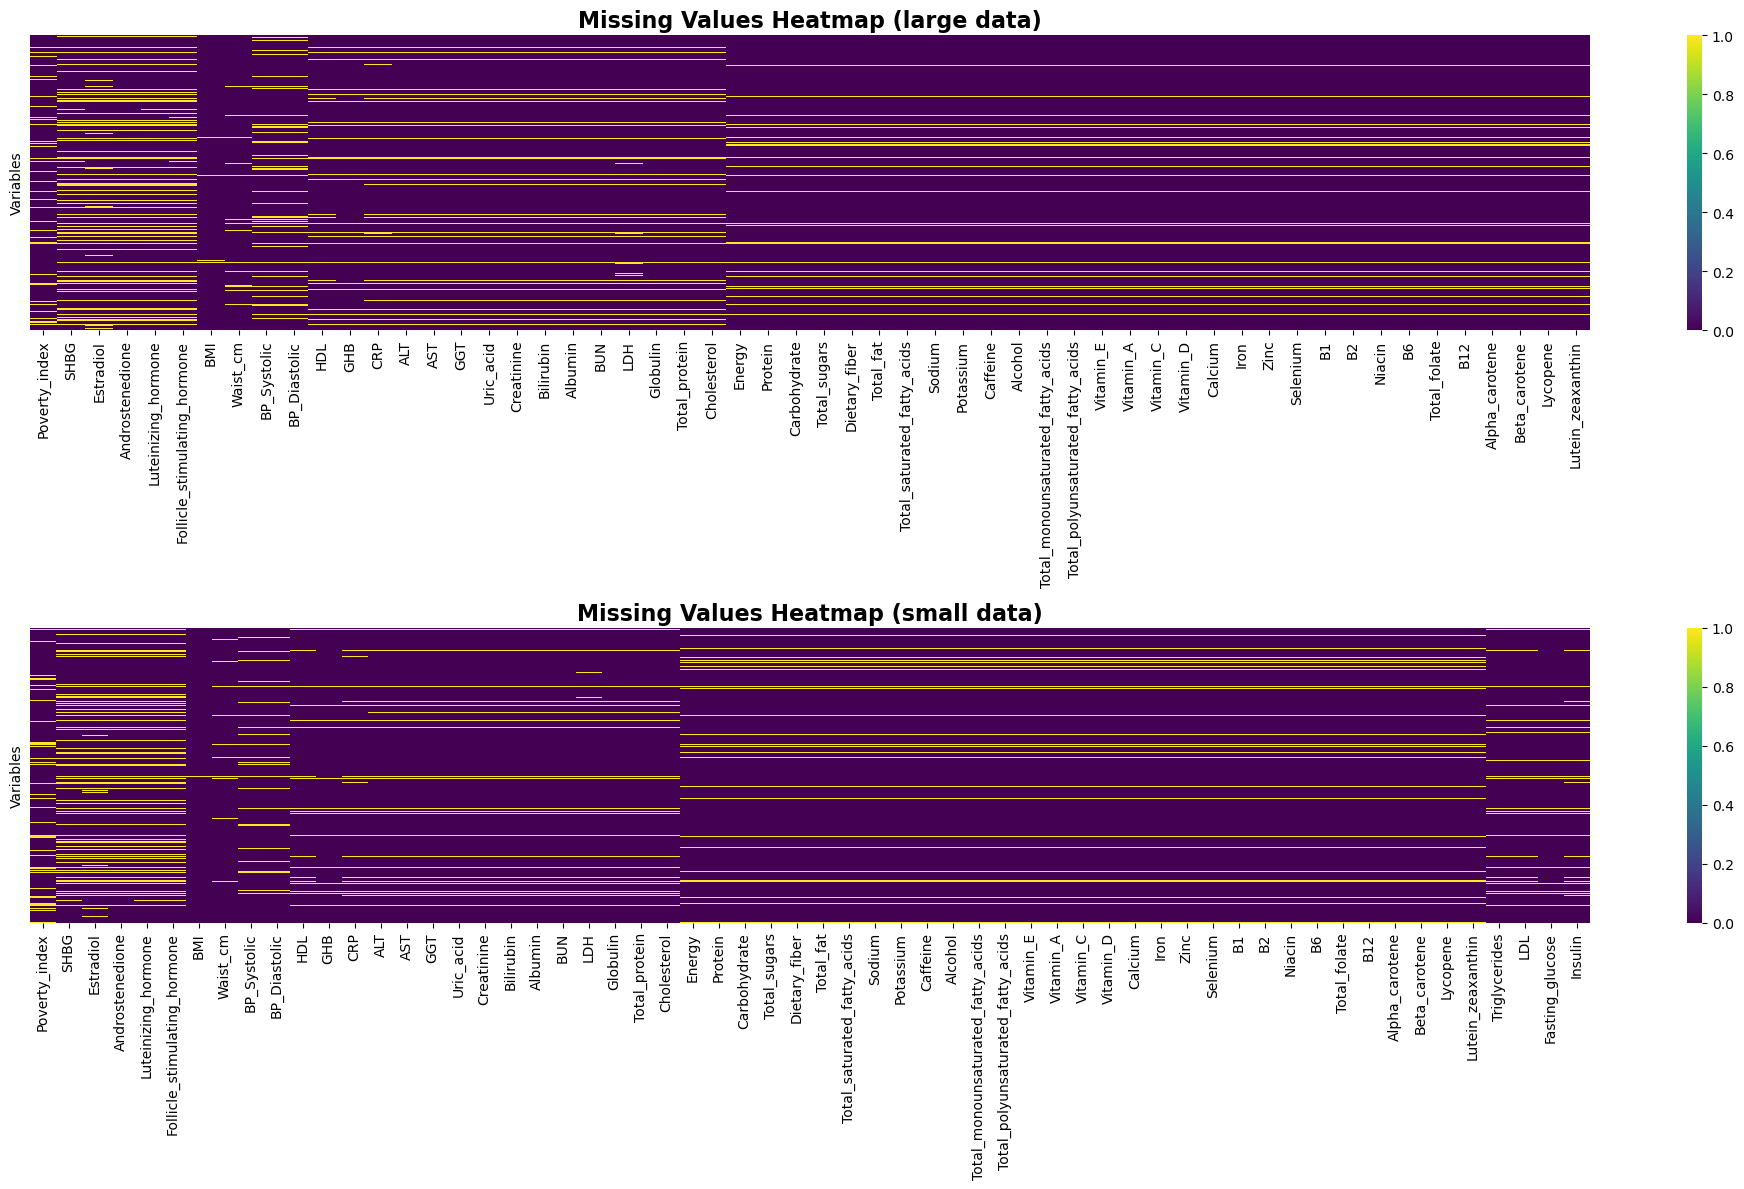

In [362]:
# Check the distribution and correlation of missing values
missing_cols_large = large_data.columns[large_data.isnull().any()].tolist()
missing_cols_small = small_data.columns[small_data.isnull().any()].tolist()

fig, ax = plt.subplots(2,figsize=(20,12))

sns.heatmap(large_data[missing_cols_large].isnull(), cmap='viridis', annot=False, yticklabels=False, ax=ax[0])
ax[0].set_title('Missing Values Heatmap (large data)', fontsize=16, fontweight='bold')
ax[0].set_ylabel('Variables')

sns.heatmap(small_data[missing_cols_small].isnull(), cmap='viridis', annot=False, yticklabels=False, ax=ax[1])
ax[1].set_title('Missing Values Heatmap (small data)', fontsize=16, fontweight='bold')
ax[1].set_ylabel('Variables')

plt.tight_layout()

In [363]:
# Find rows with more than 50% of missing values
missing_threshold = 0.5      
    
# Mask for rows to drop (have more missing values than threshold)
rows_to_drop_small = small_data.isnull().mean(axis=1) > missing_threshold
rows_to_drop_large = large_data.isnull().mean(axis=1) > missing_threshold

print(f'Rows to drop from small_data {rows_to_drop_small.sum()} out of {small_data.shape[0]}')
print(f'Rows to drop from large_data {rows_to_drop_large.sum()} out of {large_data.shape[0]}')

# Drop rows with missing values more than threshold
small_data.drop(small_data[rows_to_drop_small].index, axis=0, inplace=True)
large_data.drop(large_data[rows_to_drop_large].index, axis=0, inplace=True)

# Drop rows with missing values in Fasting_glucose column (since will be used as target in the analysis)
small_data.dropna(subset=['Fasting_glucose'], axis=0, inplace=True)

print('Percentage of missing values in small data after dropping (%):\n')
print(np.round(small_data[missing_cols_small].isnull().mean() * 100, 2))


Rows to drop from small_data 140 out of 5090
Rows to drop from large_data 467 out of 10409
Percentage of missing values in small data after dropping (%):

Poverty_index                        12.89
SHBG                                 12.62
Estradiol                            15.38
Androstenedione                      12.36
Luteinizing_hormone                  12.53
Follicle_stimulating_hormone         12.85
BMI                                   1.52
Waist_cm                              3.92
BP_Systolic                           9.27
BP_Diastolic                          9.27
HDL                                   1.95
GHB                                   0.26
CRP                                   2.61
ALT                                   2.40
AST                                   2.72
GGT                                   2.40
Uric_acid                             2.40
Creatinine                            2.36
Bilirubin                             2.36
Albumin                     

In [364]:
# Impute the rest missing values with KNN imputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Divide dataset into male and female and save datasets before imputation
small_male = small_data[small_data.Gender == 1]
small_male_before = small_male.copy()

small_female = small_data[small_data.Gender == 0]
small_female_before = small_female.copy()

large_male = large_data[large_data.Gender == 1]
large_male_before = large_male.copy()

large_female = large_data[large_data.Gender == 0]
large_female_before = large_female.copy()

small_data_before = small_data.copy()
large_data_before = large_data.copy()

# Choose numeric columns with missing values for imputation
missing_cols_large = large_data.columns[large_data.isnull().any()].tolist()
missing_cols_small = small_data.columns[small_data.isnull().any()].tolist()

# Find common and different columns in both datasets 
common_cols = list(set(missing_cols_small) & set(missing_cols_large))
only_small_cols = list(set(missing_cols_small) - set(missing_cols_large))

# Include Age column as a predictor
imputation_cols = common_cols + ['Age']

# Create function for imputing (fit_transform on large_data and transform on small_data for common columns,
# fit_transform for non-shared columns of small_data)
def impute_data(data, cols, scaler=None, imputer=None, fit=False):
    if fit:
        scaler = StandardScaler()
        imputer = KNNImputer(n_neighbors=10)
        data.loc[:, cols] = scaler.fit_transform(data[cols])
        data.loc[:, cols] = imputer.fit_transform(data[cols])

    else:
        data.loc[:, cols] = scaler.transform(data[cols])
        data.loc[:, cols] = imputer.transform(data[cols])

    # Reverse scaling
    data.loc[:, cols] = scaler.inverse_transform(data[cols])
    return data, scaler, imputer

# Impute with KNN all common columns for big_data and small_data, fitting scaler and imputer only on big_data 
large_male, common_scaler_m, common_imputer_m = impute_data(large_male, imputation_cols, fit=True)
small_male, _, _ = impute_data(small_male, imputation_cols, common_scaler_m, common_imputer_m)

large_female, common_scaler_f, common_imputer_f = impute_data(large_female, imputation_cols, fit=True)
small_female, _, _ = impute_data(small_female, imputation_cols, common_scaler_f, common_imputer_f)

# Impute the rest columns for small_data, fitting and transforming
small_data, _, _ = impute_data(small_data, only_small_cols + ['Age'], fit=True)

# Replace imputed separately for male and female values in small_data
# Alighn indices
small_male = small_male.set_index(small_data[small_data.Gender == 1].index)
small_female = small_female.set_index(small_data[small_data.Gender == 0].index)

large_male = large_male.set_index(large_data[large_data.Gender == 1].index)
large_female = large_female.set_index(large_data[large_data.Gender == 0].index)

# Update common_cols in small_data
small_data.loc[small_data.Gender == 1, common_cols] = small_male[common_cols]
small_data.loc[small_data.Gender == 0, common_cols] = small_female[common_cols]

large_data.loc[large_data.Gender == 1, common_cols] = large_male[common_cols]
large_data.loc[large_data.Gender == 0, common_cols] = large_female[common_cols]

print('Missing values of small_data after KNN imputation: ', small_data.isnull().sum().sum())
print('Missing values of large_data after KNN imputation: ', large_data.isnull().sum().sum())

Missing values of small_data after KNN imputation:  0
Missing values of large_data after KNN imputation:  0


**Validation after imputation**

In [365]:
# Check the change in correlation between variables
change_corr_small = small_data_before[missing_cols_small + ['Age']].corr() - small_data[missing_cols_small + ['Age']].corr() 

print('Small Data:\n')
print(f'Change in correlation after imputation:\n {np.round(change_corr_small, 4)}')

# Check stats before and after imputation for small_data
print('Original Data Stats (small data):\n', small_data_before[missing_cols_small].describe())
print('Imputed Data Stats (small data):\n', small_data[missing_cols_small].describe())

Small Data:

Change in correlation after imputation:
                                    Poverty_index    SHBG  Estradiol  \
Poverty_index                             0.0000  0.0042     0.0090   
SHBG                                      0.0042  0.0000    -0.0171   
Estradiol                                 0.0090 -0.0171     0.0000   
Androstenedione                           0.0013 -0.0086    -0.0163   
Luteinizing_hormone                       0.0061 -0.0111    -0.0004   
Follicle_stimulating_hormone              0.0053 -0.0102    -0.0054   
BMI                                      -0.0074 -0.0056    -0.0001   
Waist_cm                                 -0.0111 -0.0048     0.0020   
BP_Systolic                              -0.0038  0.0008     0.0149   
BP_Diastolic                             -0.0042  0.0008     0.0090   
HDL                                       0.0076 -0.0035    -0.0100   
GHB                                      -0.0031 -0.0035     0.0023   
CRP                    

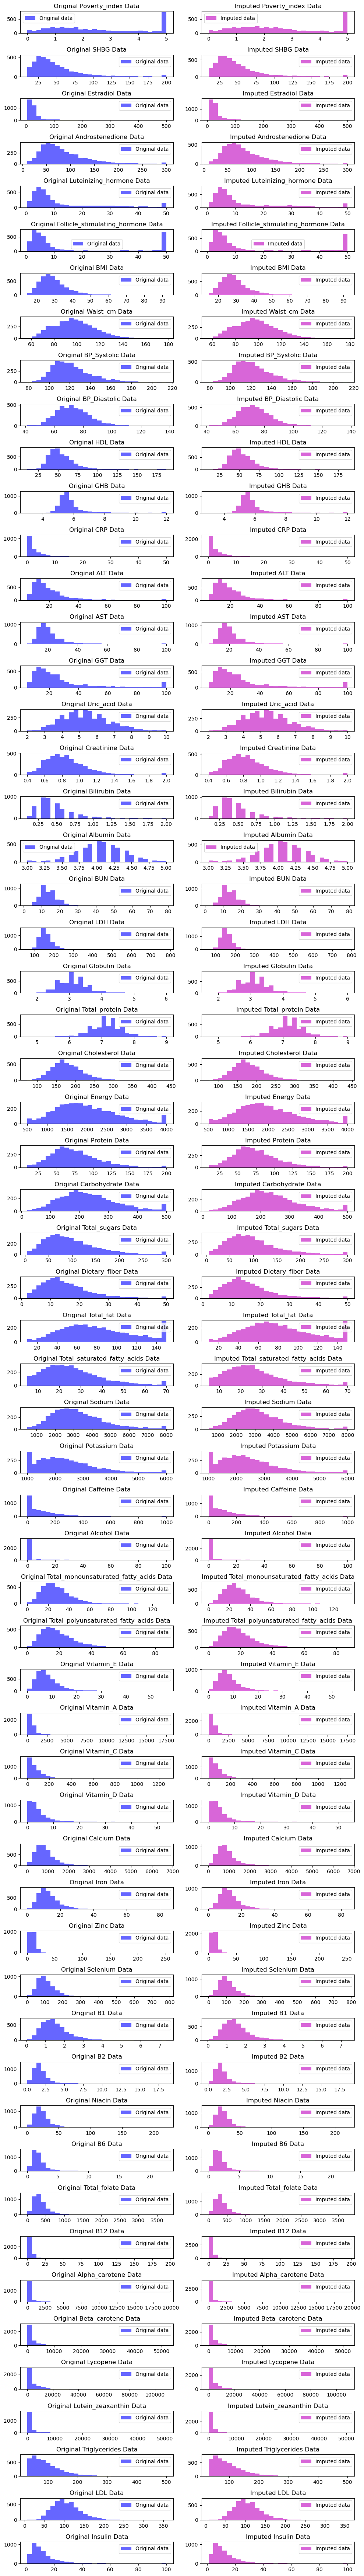

In [366]:
# Check distribution after imputation for small data
num_plots = len(missing_cols_small)

fig, ax = plt.subplots(num_plots,2, figsize=(10,70))

for i in range(num_plots):
    # Original (non-missing) data
    ax[i,0].hist(small_data_before[missing_cols_small[i]], bins=30, color='b', label='Original data', alpha=0.6)
    ax[i,0].set_title(f'Original {missing_cols_small[i]} Data')
    ax[i,0].legend()

    # Imputed data
    ax[i,1].hist(small_data[missing_cols_small[i]], bins=30, color='m', label='Imputed data', alpha=0.6)
    ax[i,1].set_title(f'Imputed {missing_cols_small[i]} Data')
    ax[i,1].legend()

plt.tight_layout()

## Merging all datasets and saving final cleaned dataframe to csv file

In [367]:
# Merge with merged sleep, physical activity and smoked status data
small_data = small_data.merge(sleep_lifestyle_diabetes, left_index=True, right_index=True)

print('Shape of Small Data after merging: ', small_data.shape)

# Calculate eGFR (estimated glomerular filtration rate) for kidney function
small_data['eGFR'] = 175 * (small_data.Creatinine ** (-1.154)) * (small_data.Age ** (-0.203))  
small_data.eGFR = small_data.apply(lambda row: row.eGFR * 0.742 if row.Gender == 0 else row.eGFR, axis=1)

# Calculate Albumin-to-Creatinine Ratio (ACR) (marker of kidney damage and cardiovascular risk)
small_data['ACR'] = small_data.Albumin / small_data.Creatinine

# Log - transform skewed features
skewed_cols = ['CRP', 'ALT', 'AST', 'GGT', 'Estradiol', 'Luteinizing_hormone', 'Follicle_stimulating_hormone', 'SHBG',
               'Triglycerides', 'Insulin', 'Fasting_glucose', 'Total_saturated_fatty_acids', 'Cholesterol','Total_sugars',
               'Caffeine', 'Alcohol', 'Creatinine', 'Vitamin_A', 'Zinc', 'B12', 'Alpha_carotene', 'Beta_carotene', 'Lycopene']

for col in skewed_cols:
    small_data[f'{col}_log'] = np.log1p(small_data[col])

print('Shape of Small Data after log-transformation:', small_data.shape)
print('Missing values: ', small_data.isnull().sum().sum())

# Save cleaned small dataset to csv file for further analysis
small_data.to_csv('circadian_metabolism_raw.csv')

Shape of Small Data after merging:  (4021, 125)
Shape of Small Data after log-transformation: (4021, 150)
Missing values:  0


In [183]:
small_data.columns[:50]

Index(['Gender', 'Age', 'Race', 'Poverty_index', 'SHBG', 'Estradiol',
       'Androstenedione', 'Luteinizing_hormone',
       'Follicle_stimulating_hormone', 'BMI', 'Waist_cm', 'BP_Systolic',
       'BP_Diastolic', 'HDL', 'GHB', 'CRP', 'ALT', 'AST', 'GGT', 'Uric_acid',
       'Creatinine', 'Bilirubin', 'Albumin', 'BUN', 'LDH', 'Globulin',
       'Total_protein', 'Cholesterol', 'Diet', 'Weight_loss_diet',
       'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Diabetic_diet',
       'Low_carbohydrate_diet', 'High_protein_diet', 'Energy', 'Protein',
       'Carbohydrate', 'Total_sugars', 'Dietary_fiber', 'Total_fat',
       'Total_saturated_fatty_acids', 'Sodium', 'Potassium', 'Caffeine',
       'Alcohol', 'Total_monounsaturated_fatty_acids',
       'Total_polyunsaturated_fatty_acids', 'Vitamin_E'],
      dtype='object')

In [184]:
small_data.columns[50:100]

Index(['Vitamin_A', 'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc',
       'Selenium', 'B1', 'B2', 'Niacin', 'B6', 'Total_folate', 'B12',
       'Alpha_carotene', 'Beta_carotene', 'Lycopene', 'Lutein_zeaxanthin',
       'Triglycerides', 'LDL', 'Fasting_glucose', 'Insulin',
       'Bedtime_weekdays', 'Wake_time_weekdays', 'Sleep_hrs_weekdays',
       'Bedtime_weekends', 'Wake_time_weekends', 'Sleep_hrs_weekends', 'Snore',
       'Stop_breathing', 'Sleeping_problems', 'Sleepy_during_day',
       'Bedtime_weekdays_hrs', 'Wake_time_weekdays_hrs',
       'Bedtime_weekends_hrs', 'Wake_time_weekends_hrs',
       'Bedtime_weekdays_hrs_sin', 'Bedtime_weekdays_hrs_cos',
       'Wake_time_weekdays_hrs_sin', 'Wake_time_weekdays_hrs_cos',
       'Bedtime_weekends_hrs_sin', 'Bedtime_weekends_hrs_cos',
       'Wake_time_weekends_hrs_sin', 'Wake_time_weekends_hrs_cos',
       'Social_Jetlag', 'Jetlag_hrs', 'Stop_breathing_missing',
       'Snore_missing', 'Sleeping_problems_missing',
       'Slee

# Analysis

In [375]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('circadian_metabolism_raw.csv')

# Main features
plottable = ['Alpha_carotene_log', 'BP_Systolic', 'LDH', 'Luteinizing_hormone_log', 'SHBG_log', 'eGFR', 'Insulin_log',
             'GGT_log', 'Androstenedione', 'Triglycerides_log', 'BUN', 'Bilirubin', 'GHB', 'ALT_log', 'Age', 'Waist_cm',
             'Sleep_midpoint_weekends','Sleep_midpoint_weekdays', 'Social_Jetlag', 'Sleep_hrs_weekdays']

# Map for cleaner layout of diabetes status
data['Diabetes_label'] = data['Diabetes'].map({0: 'Non-Diabetic', 1: 'Diabetic'})

In [97]:
data.Diabetes_label.value_counts()

Diabetes_label
Non-Diabetic    3276
Diabetic         745
Name: count, dtype: int64

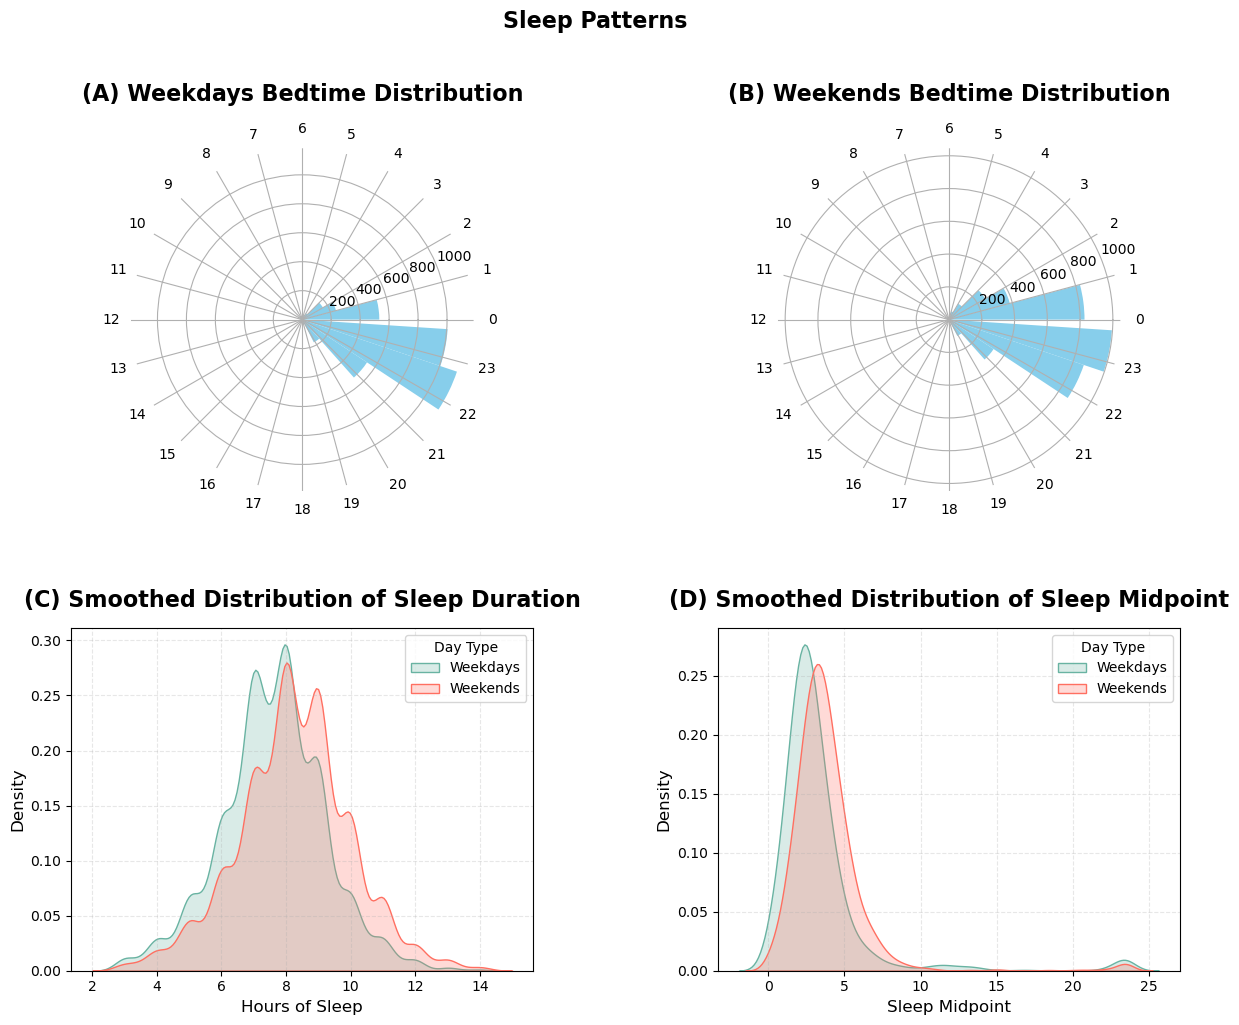

In [148]:
cols = ['Bedtime_weekdays_hrs', 'Bedtime_weekends_hrs']
titles = ['(A) Weekdays Bedtime Distribution', '(B) Weekends Bedtime Distribution']

cols_hrs = ['Sleep_hrs_weekdays', 'Sleep_hrs_weekends']
titles_hrs = ['Sleep Hours (Weekdays)', 'Sleep Hours (Weekends)']
colors = ['lightcoral', 'mediumseagreen']

fig = plt.figure(figsize=(12,10))

# Polar plots
for i in range(2):
    # Create polar axis
    ax = fig.add_subplot(2, 2, i+1, projection='polar', 
                        frame_on=False)    # No frame from start
    
    # Convert hours to angles
    angles = 2 * np.pi * data[cols[i]] / 24
    ax.hist(angles, bins=24, color='skyblue')
    ax.set_title(titles[i], fontsize=16, pad=15, weight='semibold')
    
    # Set hour labels
    ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
    ax.set_xticklabels([str(h) for h in range(24)])

# Customized colors
colors = ['#69b3a2', '#ff6f61'] 

# 'Sleep_hrs_weekdays' and 'Sleep_hrs_weekends'
ax = fig.add_subplot(2, 2, 3)
sns.kdeplot(data['Sleep_hrs_weekdays'].dropna(), label='Weekdays', fill=True, color=colors[0])
sns.kdeplot(data['Sleep_hrs_weekends'].dropna(), label='Weekends', fill=True, color=colors[1])

ax.set_title('(C) Smoothed Distribution of Sleep Duration', fontsize=16, pad=15, weight='semibold')
ax.set_xlabel('Hours of Sleep', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

ax.legend(title='Day Type')
ax.grid(True, linestyle='--', alpha=0.3)

# 'Sleep_midpoint_weekdays' and 'Sleep_midpoint_weekends' smoothed distribution
ax = fig.add_subplot(2, 2, 4)
sns.kdeplot(data['Sleep_midpoint_weekdays'].dropna(), label='Weekdays', fill=True, color=colors[0])
sns.kdeplot(data['Sleep_midpoint_weekends'].dropna(), label='Weekends', fill=True, color=colors[1])

ax.set_title('(D) Smoothed Distribution of Sleep Midpoint', fontsize=16, pad=15, weight='semibold')
ax.set_xlabel('Sleep Midpoint', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

ax.legend(title='Day Type')
ax.grid(True, linestyle='--', alpha=0.3)

# Add universal formatting
plt.suptitle('Sleep Patterns', y=1.02, fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Increase spacing between plots

# Save combined plot
plt.savefig('bedtime_distribution.png', 
           dpi=300, 
           bbox_inches='tight',
           transparent=True)
plt.show()

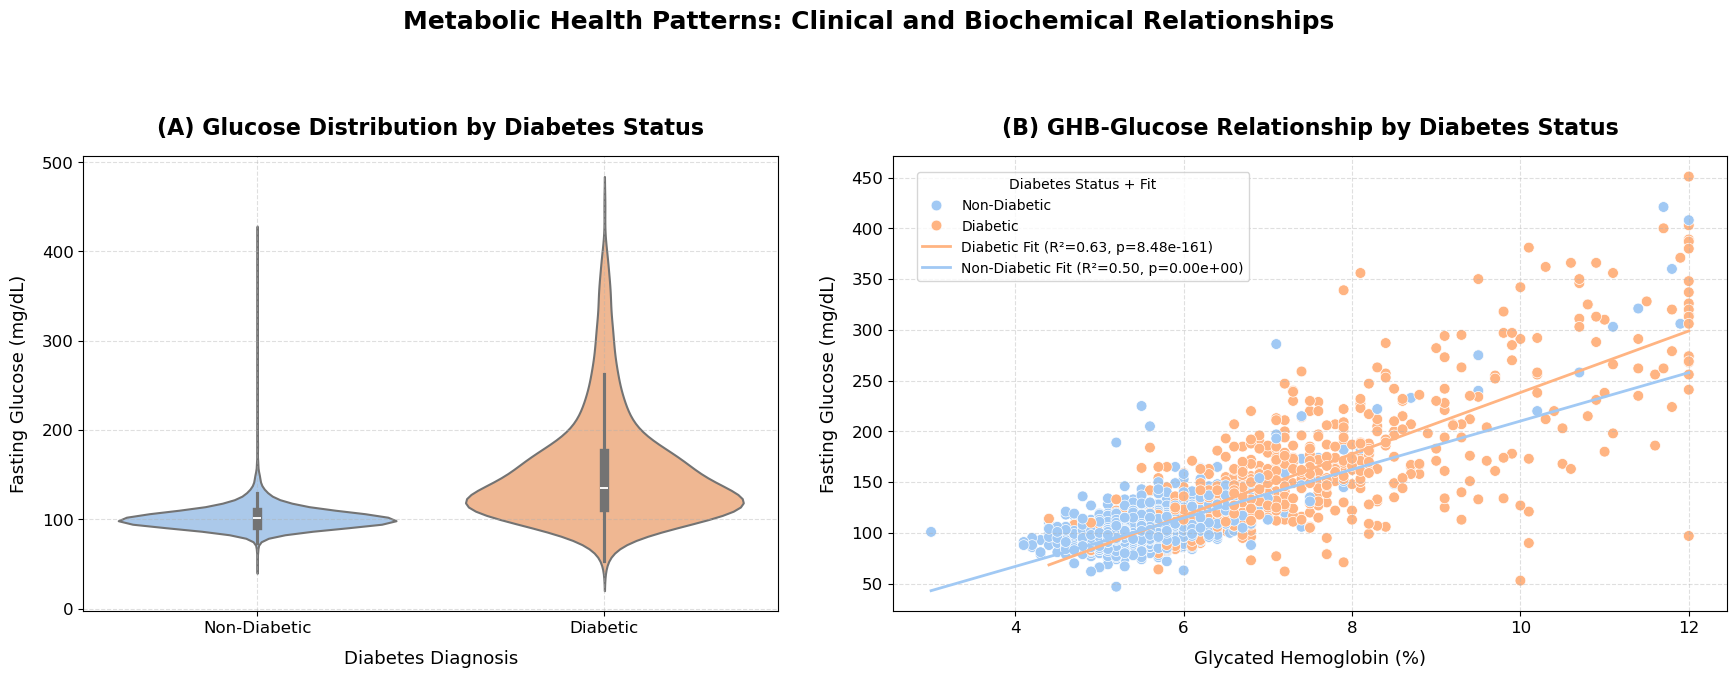

In [149]:
from scipy.stats import linregress

# Create combined figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot A: Diabetes Status Distribution
sns.violinplot(ax=ax1,
               x='Diabetes_label', 
               y='Fasting_glucose',
               data=data,
               palette='pastel',
               hue='Diabetes_label',
               inner='box',
               linewidth=1.5)

ax1.set_title('(A) Glucose Distribution by Diabetes Status', 
             fontsize=16, pad=15, weight='semibold')
ax1.set_xlabel('Diabetes Diagnosis', fontsize=13, labelpad=10)
ax1.set_ylabel('Fasting Glucose (mg/dL)', fontsize=13, labelpad=10)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.4, linewidth=0.8)
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
    
# Plot B: Scatterplot
sc = sns.scatterplot(ax=ax2,
                    x='GHB',
                    y='Fasting_glucose',
                    data=data,
                    hue='Diabetes_label',
                    palette='pastel',
                    s=60,
                    edgecolor='w',
                    linewidth=0.5)

# Define color palette to match the scatter
palette_dict = dict(zip(data['Diabetes_label'].unique(), sns.color_palette('pastel')))

# Loop through groups to add separate regression lines
for label, group_data in data.groupby('Diabetes_label'):
    x = group_data['GHB']
    y = group_data['Fasting_glucose']
    slope, intercept, r, p, std_err = linregress(x, y)
    
    # Best fit line
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = intercept + slope * x_vals
    ax2.plot(x_vals, y_vals, label=f'{label} Fit (R²={r**2:.2f}, p={p:.2e})',
             color=palette_dict[label], linestyle='-', lw=2)

# Formatting
ax2.set_title('(B) GHB-Glucose Relationship by Diabetes Status', 
             fontsize=16, pad=15, weight='semibold')
ax2.set_xlabel('Glycated Hemoglobin (%)', fontsize=13, labelpad=10)
ax2.set_ylabel('Fasting Glucose (mg/dL)', fontsize=13, labelpad=10)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True, linestyle='--', alpha=0.4, linewidth=0.8)

# Legend 
ax2.legend(title='Diabetes Status + Fit', bbox_to_anchor=(0.02, 0.98), loc='upper left')

# Add universal formatting
plt.suptitle('Metabolic Health Patterns: Clinical and Biochemical Relationships', 
            y=1.0, fontsize=18, weight='bold')

plt.tight_layout(pad=3)
plt.savefig('metabolic_relationships.png', dpi=400, bbox_inches='tight')
plt.show()

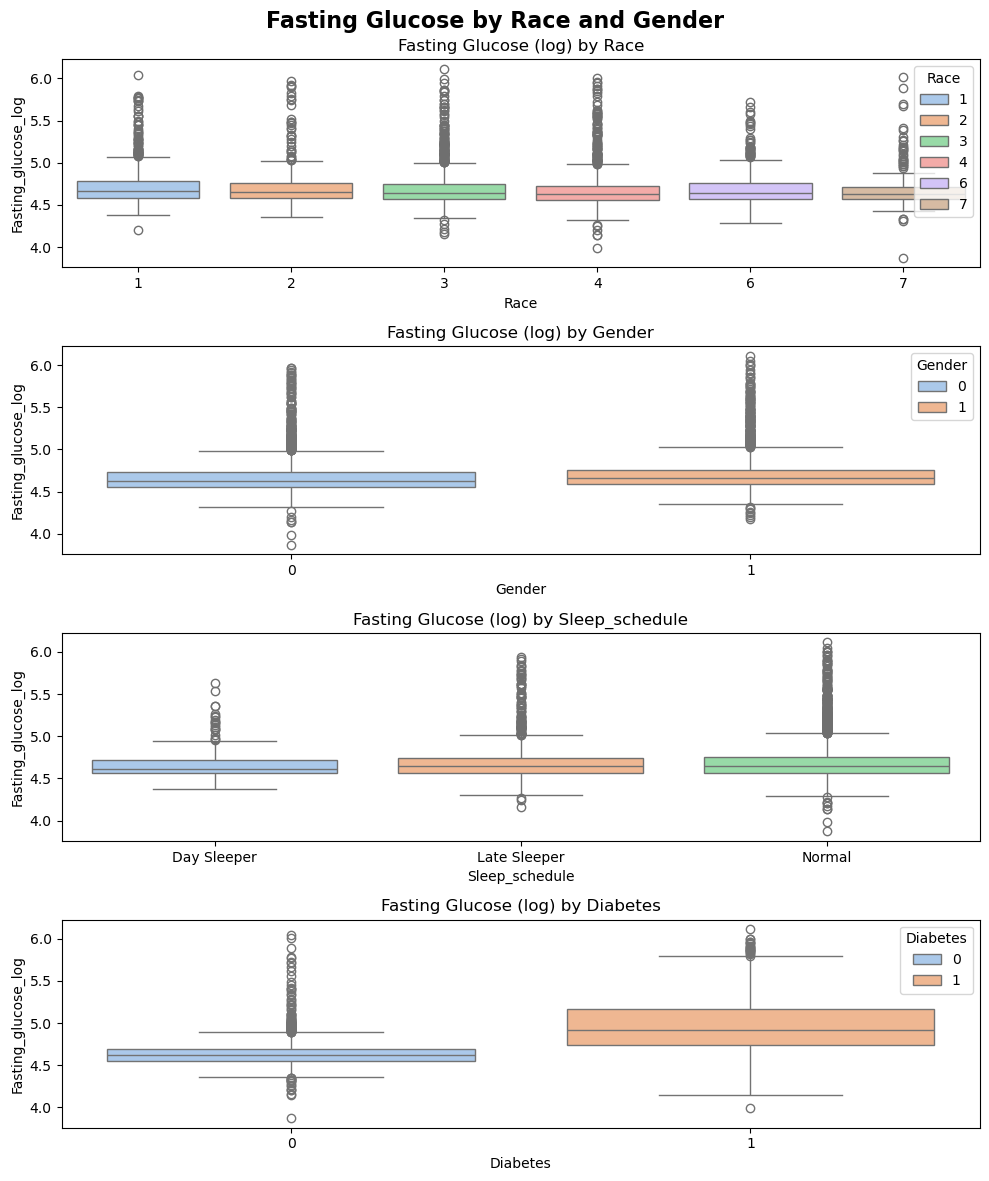

In [307]:
box_plot_cols = ['Race', 'Gender', 'Sleep_schedule', 'Diabetes']

fig, ax = plt.subplots(4,figsize=(10,12))

for i in range(len(box_plot_cols)):
    sns.boxplot(x=box_plot_cols[i],
                y='Fasting_glucose_log',
                data=data,
                palette='pastel',
                hue=box_plot_cols[i],
                ax=ax[i])
    
    ax[i].set_title(f'Fasting Glucose (log) by {box_plot_cols[i]}')
    
plt.suptitle('Fasting Glucose by Race and Gender', fontsize=16, fontweight='bold')
plt.savefig('boxplot_final_features.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

# 'Race': 1	- Mexican American,	2 -	Other Hispanic,	3 -	Non-Hispanic White,	4 -	Non-Hispanic Black,	
#         6 - Non-Hispanic Asian, 7 - Other Race (Including Multi-Racial)

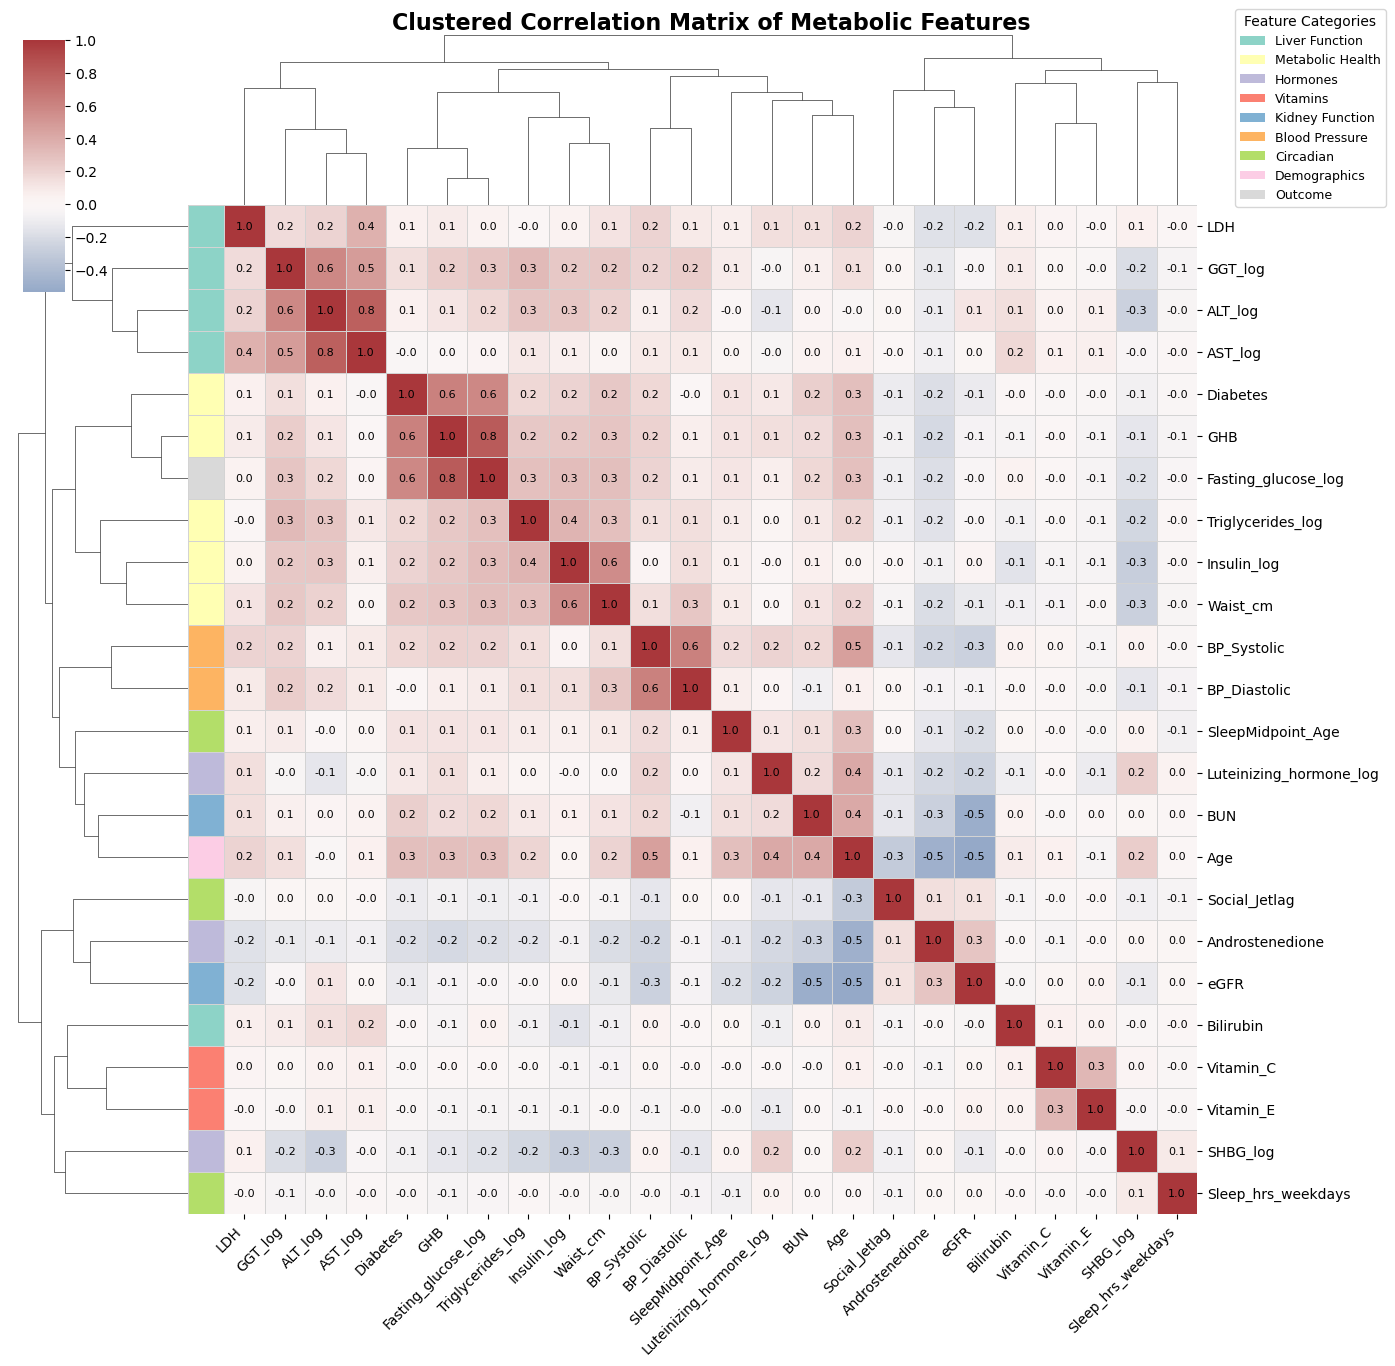

In [92]:
from itertools import cycle
from matplotlib.patches import Patch

# Define features of interest with clinical groupings
biomarker_groups = {
    'Liver Function': ['GGT_log', 'ALT_log', 'AST_log', 'Bilirubin', 'LDH'],
    'Metabolic Health': ['GHB', 'Insulin_log', 'Triglycerides_log', 'Waist_cm', 'Diabetes'],
    'Hormones': ['SHBG_log', 'Androstenedione', 'Luteinizing_hormone_log'],
    'Vitamins': ['Vitamin_C', 'Vitamin_E'],
    'Kidney Function': ['eGFR', 'BUN'],
    'Blood Pressure': ['BP_Systolic', 'BP_Diastolic'],
    'Circadian': ['SleepMidpoint_Age', 'Social_Jetlag', 'Sleep_hrs_weekdays'],
    'Demographics': ['Age'],
    'Outcome': ['Fasting_glucose_log'] 
}

# Flatten grouped features for selection
plottable = [feat for group in biomarker_groups.values() for feat in group]

# Create a mapping of feature to group color
group_colors = dict(zip(biomarker_groups.keys(), sns.color_palette('Set3', n_colors=len(biomarker_groups))))

# Assign each feature the color of its group
row_colors = []
for group_name, features in biomarker_groups.items():
    color = group_colors[group_name]
    for feat in features:
        if feat in corr.columns:
            row_colors.append(color)

# Prepare data matrix with z-score normalization
df_cluster = data[plottable].select_dtypes(include='number').dropna()
# Standardize for comparable color scaling
df_cluster = df_cluster.apply(zscore)  

# Calculate correlations with precision
corr = df_cluster.corr(method='pearson').round(2)

# Create clustermap
g = sns.clustermap(
    corr,
    cmap='vlag',
    center=0,
    annot=True,
    annot_kws={'size': 8, 'color': 'black'},
    fmt='.1f',
    linewidths=0.5,
    linecolor='lightgray',
    figsize=(14, 14),
    dendrogram_ratio=(0.15, 0.15),
    cbar_pos=(0.02, 0.8, 0.03, 0.18),
    row_colors=row_colors,
)


# Customize xticklabels and yticklabels
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(), 
    rotation=45, 
    ha='right',
    fontsize=10
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(), 
    rotation=0,
    fontsize=10
)

# Add explanatory text
plt.text(0.5, 1.18, 'Clustered Correlation Matrix of Metabolic Features',
        ha='center', va='center', 
        transform=g.ax_heatmap.transAxes, 
        fontsize=16, fontweight='bold')

# Create legend for clinical groups
handles = [Patch(facecolor=color) 
          for color in sns.color_palette('Set3', len(biomarker_groups))]
g.ax_heatmap.legend(
    handles, biomarker_groups.keys(),
    bbox_to_anchor=(1.2, 1.2), 
    title='Feature Categories',
    fontsize=9
)

plt.savefig('enhanced_cluster_heatmap.png', 
           dpi=300, 
           bbox_inches='tight',
           transparent=False)
plt.show()

# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import shap

In [93]:
# Load data
data = pd.read_csv('circadian_metabolism_raw.csv')

# Age subgroup
age_bins = [18, 35, 60, 100]
age_labels = ['Young (18-35)', 'Middle (35-60)', 'Senior (60+)']
data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# BMI subgroup
bmi_bins = [0, 25, 30, 100]
bmi_labels = ['Normal', 'Overweight', 'Obese']
data['BMI_Group'] = pd.cut(data['BMI'], bins=bmi_bins, labels=bmi_labels, include_lowest=True)

# Sleep hours category
sleep_hrs_bins = [0, 6.5, 9.5, 24]
sleep_hrs_labels = ['Short_Sleep', 'Optimal_Sleep', 'Long_Sleep']
data['Sleep_hrs_Category'] = pd.cut(data.Sleep_hrs_weekdays, bins=sleep_hrs_bins, labels=sleep_hrs_labels)

# Combine age, gender, and BMI into a stratification column
data['stratify_col'] = (
    data['Age_Group'].astype(str) + '_' + 
    data['Gender'].astype(str) + '_' + 
    data['BMI_Group'].astype(str)
)

# Drop rows with NaNs in stratification variables before splitting
#data = data.dropna(subset=['Age_Group', 'Gender', 'BMI_Group'])
data = data.dropna(subset=['Age_Group'])

# Convert object columns to categorical 
object_cols = data.select_dtypes(include=['object']).columns.tolist()
data[object_cols] = data[object_cols].astype('category')

# Binary categorical features (except Race), do not need OHE
cat_cols_int = ['Smoked', 'Race', 'Gender', 'Cancer_coded', 'Diabetes_family_history_coded', 'Diabetes', 'Diet', 'Weight_loss_diet',
                'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet', 'High_protein_diet',
                'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational'
               ]
# Insure these categorical features are of type in
data[cat_cols_int] = data[cat_cols_int].astype(int)

# Define variable to use for analysis
metabolic_vars = ['BMI', 'Waist_cm', 'HDL', 'GHB', 'CRP_log', 'ALT_log', 'AST_log', 'GGT_log', 'Uric_acid',
                  'Triglycerides_log', 'LDL', 'eGFR', 'ACR', 'Insulin_log',
                  'Bilirubin', 'BP_Systolic', 'BP_Diastolic', 'Fasting_glucose_log', 'BUN', 'LDH', 'Globulin',
                  'Total_protein', 'Cholesterol_log', 'Creatinine_log'
                 ]

circadian_vars = ['Bedtime_weekdays_hrs_sin', 'Sleep_health', 'Jetlag_hrs', 'Sleep_Apnea_risk',
                  'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends', 'Sleep_hrs_Category',
                  'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_hrs_weekdays', 'Sleep_schedule']

lifestyle_vars = ['Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational',
                  'Diabetes_family_history_coded', 'Cancer_coded', 'Lifestyle_score', 'Sedentary_hrs', 'Smoked', # 'Activity_score',
                 'Activity_category', 'Sedentary_category', 'Lifestyle_category', 'Diabetes']


hormones_vars = [ 'SHBG_log', 'Estradiol_log', 'Androstenedione', 'Luteinizing_hormone_log', 'Follicle_stimulating_hormone_log']

nutrients_vars = ['Energy', 'Protein', 'Carbohydrate', 'Dietary_fiber', # 'Total_sugars_log','Total_fat',
                   'Sodium', 'Potassium', 'Caffeine_log', 'Alcohol_log', 'Total_saturated_fatty_acids_log',
                  'Total_monounsaturated_fatty_acids', 'Total_polyunsaturated_fatty_acids', 'Vitamin_E', 'Vitamin_A_log',
                  'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc_log', 'Selenium', 'B1', 'B2', 'Niacin', 'B6', 
                  'Total_folate', 'B12_log', 'Alpha_carotene_log', 'Beta_carotene_log', 'Lycopene_log', 'Lutein_zeaxanthin',
                  'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet',
                  'High_protein_diet'
                 ] 

control_vars = ['Gender', 'Age', 'Race', 'Poverty_index']

### Remove highly correlated features

In [76]:
numerical_vars = metabolic_vars + circadian_vars + lifestyle_vars + hormones_vars + nutrients_vars
numerical_data = data[numerical_vars].select_dtypes(include=['number']).drop(columns=['Fasting_glucose_log'])

# Compute correlation matrix
corr_matrix = numerical_data.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find highly correlated pairs
high_corr_pairs = [(col, idx, upper.loc[col, idx]) 
                   for col in upper.columns for idx in upper.index 
                   if upper.loc[col, idx] > 0.85]

# Convert to DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Features to drop from each pair
features_to_drop = list(set(high_corr_df['Feature 1'].values))
features_to_drop

['Protein',
 'Luteinizing_hormone_log',
 'BMI',
 'ACR',
 'LDL',
 'Jetlag_hrs',
 'Niacin',
 'Energy']

In [5]:
#!pip install prettytable
# Customized colors for the plots
blues_cmap = plt.get_cmap('Blues')

# Table for model comparison
from prettytable import PrettyTable

# Create a table instance
table = PrettyTable()

# Create headers
table.field_names = ['Model', 'MAE', 'R^2 (Train)', 'R^2 (Test)', 'R^2 (Cross-validated)', 'Features']
print(table)

+-------+-----+-------------+------------+-----------------------+----------+
| Model | MAE | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | Features |
+-------+-----+-------------+------------+-----------------------+----------+
+-------+-----+-------------+------------+-----------------------+----------+


In [6]:
# Function for evaluating models
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, feature_names, table):
    '''
    Evaluates model, adds results to the comparison table and returns all key metrics.
    
    Parameters:
    - model: Trained classifier model
    - model_name: Name of the model for titles
    - X_train: Processed training features
    - y_train: Training target
    - X_test: Processed test features
    - y_test: Test target
    - feature_names: List of feature names
    - table: Table to store results
    
    '''
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # K-Fold validation (5-fold CV)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Add results to the table
    table.add_row([model_name, np.round(mae, 4), np.round(r2_train, 4), np.round(r2_test, 4),
                  f'{np.round(scores.mean(), 3)} ± {np.round(scores.std(), 3)}', len(feature_names)])

    # Compute permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
    perm_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': r.importances_mean,
        'importance_std': r.importances_std
    })

    perm_importance_df = perm_importance_df.sort_values(by='importance_mean', ascending=False)

    return {
        'MAE': np.round(mae, 4),
        'R^2 (Train)': np.round(r2_train, 4),
        'R^2 (Test)': np.round(r2_test, 4),
        'R^2 (K-Fold validated)': f'{np.round(scores.mean(), 3)} ± {np.round(scores.std(), 3)}',
        'Permutation Importance': perm_importance_df
    }
    

## Define Data Pipeline

In [94]:
# Select features and target
X = data[control_vars + circadian_vars + metabolic_vars + hormones_vars + nutrients_vars + lifestyle_vars]
# Drop highly correlated features and target
X = X.drop(columns=['Fasting_glucose_log'] + features_to_drop)
y = data.Fasting_glucose_log

# Split into train, validation, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=data['Age_Group'], random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=data.loc[X_train_val.index, 'Age_Group'], random_state=0
)

# Define numerical and categorical columns
num_cols = X.select_dtypes(include='number').columns.drop(['Race', 'Gender']).tolist()
#num_cols = X.select_dtypes(include='number').columns.drop(cat_cols_int).tolist()
cat_cols = X.select_dtypes(include='category').columns.tolist() + ['Race']


# Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
                                 remainder='passthrough')

# Fit preprocessor on training data
preprocessor.fit(X_train)

# Get feature names out after preprocessing and and align them across transformed train, validation and test sets
feature_names = preprocessor.get_feature_names_out()
feature_names_cleaned = [name.split('__')[-1] for name in feature_names]

# Transform all sets using the fitted preprocessor
X_train_transformed = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=feature_names)
X_val_transformed = pd.DataFrame(preprocessor.transform(X_val), index=X_val.index, columns=feature_names)
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), index=X_test.index, columns=feature_names)
X_transformed = pd.DataFrame(preprocessor.transform(X), index=X.index, columns=feature_names)

In [37]:
# Check the distribution of age in test set after splitting
test_age_distribution = data.loc[X_test.index, 'Age_Group'].value_counts()
print('Test Set Age Groups:\n', test_age_distribution)

Test Set Age Groups:
 Age_Group
Middle (35-60)    324
Senior (60+)      262
Young (18-35)     219
Name: count, dtype: int64


### Summary table

In [95]:
from scipy.stats import kruskal, chi2_contingency

metabolic_vars_original = [
    'BMI', 'Waist_cm', 'HDL', 'GHB', 'CRP', 'ALT', 'AST', 'GGT', 'Uric_acid',
    'Triglycerides', 'LDL', 'eGFR', 'ACR', 'Insulin',
    'Bilirubin', 'BP_Systolic', 'BP_Diastolic', 'Fasting_glucose', 'BUN', 'LDH', 'Globulin',
    'Total_protein', 'Cholesterol', 'Creatinine'
                 ]
circadian_vars_original = [
    'Bedtime_weekdays_hrs', 'Jetlag_hrs',
    'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends', 'Sleep_hrs_Category',
    'Sleep_hrs_weekdays', 'Sleep_schedule'
]
lifestyle_vars_original = [
    'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational',
    'Diabetes_family_history', 'Cancer', 'Sedentary_hrs', 'Smoked',
    'Activity_category', 'Sedentary_category', 'Lifestyle_category', 'Diabetes'
]
hormones_vars_original = [ 'SHBG', 'Estradiol', 'Androstenedione', 'Luteinizing_hormone', 'Follicle_stimulating_hormone']
nutrients_vars_original = [
    'Energy', 'Protein', 'Carbohydrate', 'Dietary_fiber',
    'Sodium', 'Potassium', 'Caffeine', 'Alcohol', 'Total_saturated_fatty_acids',
    'Total_monounsaturated_fatty_acids', 'Total_polyunsaturated_fatty_acids', 'Vitamin_E', 'Vitamin_A',
    'Vitamin_C', 'Vitamin_D', 'Calcium', 'Iron', 'Zinc', 'Selenium', 'B1', 'B2', 'Niacin', 'B6', 
    'Total_folate', 'B12', 'Alpha_carotene', 'Beta_carotene', 'Lycopene', 'Lutein_zeaxanthin',
    'Diet', 'Weight_loss_diet', 'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet',
    'High_protein_diet'
                 ] 
control_vars = ['Gender', 'Age', 'Race', 'Poverty_index']
all_vars = (
    control_vars + metabolic_vars_original + circadian_vars_original + lifestyle_vars_original + hormones_vars_original + nutrients_vars_original
)

# Copy data and assign dataset split labels
df_final = data[all_vars].copy()
df_final['set'] = 'unassigned'
df_final.loc[X_train.index, 'set'] = 'train'
df_final.loc[X_val.index, 'set'] = 'val'
df_final.loc[X_test.index, 'set'] = 'test'


cat_cols = [
    'Smoked', 'Race', 'Gender', 'Cancer', 'Diabetes_family_history', 'Diabetes', 'Diet', 'Weight_loss_diet',
    'Low_fat_diet', 'Low_salt_diet', 'Sugar_free_diet', 'Low_carbohydrate_diet', 'High_protein_diet',
    'Vigorous_work', 'Moderate_work', 'Walk_or_bicycle', 'Vigorous_recreational', 'Moderate_recreational',
    'Activity_category', 'Sedentary_category', 'Lifestyle_category', 'Sleep_hrs_Category', 'Sleep_schedule'
               ]


# Create summary dictionary
summary_data = []

for var in all_vars:
    row = {'Variable': var}

    # Categorical variables
    if var in cat_cols:
        try:
            contingency = pd.crosstab(df_final[var], df_final.set)
            _, p, _, _ = chi2_contingency(contingency)
            row['p'] = f'{p:.3f}'
        except Exception as e:
            row['p'] = 'NA'

        for group in ['train', 'val', 'test']:
            counts = df_final[df_final.set == group][var].value_counts(dropna=False)
            total = counts.sum()
            cat_summary = []
            for cat, count in counts.items():
                pct = 100 * count / total
                cat_summary.append(f'{cat}: {count} ({pct:.1f}%)')
            row[group] = '\n'.join(cat_summary)

    # Continious variables
    else: 
        try:
            for group in ['train', 'val', 'test']:
                subset = df_final[df_final.set == group][var].dropna()
                q1 = subset.quantile(0.25)
                q2 = subset.median()
                q3 = subset.quantile(0.75)
                row[group] = f'{q2:.2f} ({q1:.2f}, {q3:.2f})'

            # Kruskal-Wallis test for p-value
            data = [df_final[df_final.set == g][var].dropna() for g in ['train', 'val', 'test']]
            _, p = kruskal(*data)
            row['p'] = f'{p:.3f}'
        except Exception as e:
            row['train'] = row['val'] = row['test'] = 'Error'
            row['p'] = 'NA'

    summary_data.append(row)

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

,Variable,p,train,val,test
0,Gender,0.691,0: 1229 (51.0%)\n1: 1183 (49.0%),0: 420 (52.2%)\n1: 384 (47.8%),0: 422 (52.4%)\n1: 383 (47.6%)
1,Age,0.981,"51.00 (34.00, 64.00)","52.00 (33.00, 64.00)","51.00 (34.00, 64.00)"
2,Race,0.831,3: 825 (34.2%)\n4: 599 (24.8%)\n1: 332 (13.8%)...,3: 277 (34.5%)\n4: 202 (25.1%)\n6: 104 (12.9%)...,3: 274 (34.0%)\n4: 200 (24.8%)\n6: 110 (13.7%)...
3,Poverty_index,0.523,"2.27 (1.32, 3.75)","2.31 (1.39, 3.98)","2.25 (1.26, 3.79)"
4,BMI,0.275,"28.40 (24.60, 33.50)","28.30 (24.50, 32.70)","28.90 (25.00, 33.80)"
...,...,...,...,...,...
84,Low_fat_diet,0.705,0: 2377 (98.5%)\n1: 35 (1.5%),0: 789 (98.1%)\n1: 15 (1.9%),0: 793 (98.5%)\n1: 12 (1.5%)
85,Low_salt_diet,0.757,0: 2368 (98.2%)\n1: 44 (1.8%),0: 786 (97.8%)\n1: 18 (2.2%),0: 789 (98.0%)\n1: 16 (2.0%)
86,Sugar_free_diet,0.853,0: 2390 (99.1%)\n1: 22 (0.9%),0: 798 (99.3%)\n1: 6 (0.7%),0: 799 (99.3%)\n1: 6 (0.7%)
87,Low_carbohydrate_diet,0.070,0: 2370 (98.3%)\n1: 42 (1.7%),0: 787 (97.9%)\n1: 17 (2.1%),0: 799 (99.3%)\n1: 6 (0.7%)


## 1. Baseline Regression Model: Elastic Net Model

ElasticNet model has been chosen due to its ability to handle multicollinearity well

In [8]:
from sklearn.linear_model import ElasticNet
from scipy.stats import uniform

param_grid = {
    'alpha': uniform(0.001, 1),
    'l1_ratio': uniform(0,1)
}

# Randomized search with 5-fold CV to find best parameters
random_search = RandomizedSearchCV(ElasticNet(),
                                   param_grid,
                                   n_iter=20,
                                   cv=5,
                                   scoring='r2',
                                   random_state=0,
                                   n_jobs=-1)
random_search.fit(X_train_transformed, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print('Best parameters: ', best_params)

# The final model with the best hyperparameters
best_model = ElasticNet(**best_params)

# Train the best model
best_model.fit(X_train_transformed, y_train)

# Evaluate results
results = evaluate_model(best_model,
                         '1. ElasticNet (Full Features)',
                         X_train_transformed, y_train,
                         X_test_transformed, y_test,
                         feature_names_cleaned,
                         table)
print(results)

Best parameters:  {'alpha': 0.07203605819788694, 'l1_ratio': 0.08712929970154071}
{'MAE': 0.0919, 'R^2 (Train)': 0.6936, 'R^2 (Test)': 0.7256, 'R^2 (K-Fold validated)': '0.681 ± 0.044', 'Permutation Importance':               feature  importance_mean  importance_std
12                GHB     8.795052e-01        0.040503
77           Diabetes     3.890956e-02        0.004765
20        Insulin_log     1.170699e-02        0.003197
21          Bilirubin     4.126829e-03        0.000853
18  Triglycerides_log     3.751415e-03        0.000813
..                ...              ...             ...
37          Potassium    -1.110223e-16        0.000000
36             Sodium    -1.110223e-16        0.000000
35      Dietary_fiber    -1.110223e-16        0.000000
34       Carbohydrate    -1.110223e-16        0.000000
95             Gender    -1.110223e-16        0.000000

[96 rows x 3 columns]}


## 2. XGBoost Model 

### 1. XGBoost model with full features

Best parameters:  {'subsample': 0.7, 'reg_lambda': 15, 'reg_alpha': 0.1, 'n_estimators': 1500, 'min_child_weight': 15, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.05, 'colsample_bytree': 0.8}
{'MAE': 0.0852, 'R^2 (Train)': 0.7838, 'R^2 (Test)': 0.7527, 'R^2 (K-Fold validated)': '0.701 ± 0.049', 'Permutation Importance':                               feature  importance_mean  importance_std
12                                GHB         0.998242        0.052932
77                           Diabetes         0.020823        0.004348
20                        Insulin_log         0.016001        0.003776
0                                 Age         0.014631        0.002107
16                            GGT_log         0.007705        0.002410
..                                ...              ...             ...
45                          Vitamin_C        -0.000494        0.001102
40    Total_saturated_fatty_acids_log        -0.000505        0.000381
36                             So

100%|===================| 802/804 [00:17<00:00]        

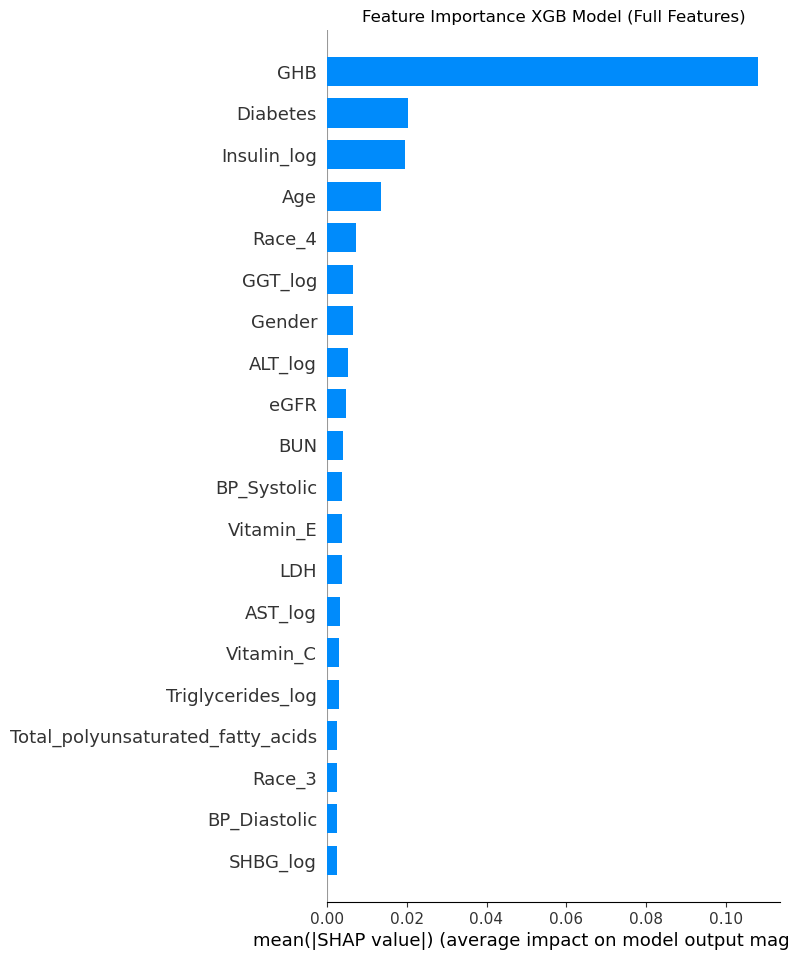

<Figure size 640x480 with 0 Axes>

In [10]:
# Define parameters grid for tuning
param_grid = {
    'n_estimators': [1000, 1200, 1500],
    'learning_rate': [0.01, 0.015, 0.02],
    
    'max_depth': [2, 3],
    'min_child_weight': [10, 12, 15],
    
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],

    'reg_alpha': [0.1, 0.2],
    'reg_lambda': [10, 15, 20],
    'gamma': [0.05, 0.1]
}

# Grid serch
random_grid = RandomizedSearchCV(XGBRegressor(enable_categorical=False, random_state=0),
                                 param_grid,
                                 n_iter=50,
                                 cv=5,
                                 scoring='r2',
                                 n_jobs=-1,
                                 verbose=0)

random_grid.fit(X_train_transformed, y_train)

# Get the best hyperparameters
best_params = random_grid.best_params_
print('Best parameters: ', best_params)

# Initialize model with the best hyperparameters
best_model = XGBRegressor(**best_params, random_state=0)

# Train the best model
best_model.fit(X_train_transformed, y_train,
               eval_set=[(X_val_transformed, y_val)],
               verbose=0)

# Evaluate results
results = evaluate_model(best_model,
                         '2. XGBoost (Full Features)',
                         X_train_transformed, y_train,
                         X_test_transformed, y_test,
                         feature_names_cleaned,
                         table)
print(results)

# Analize feature importance with SHAP
explainer = shap.Explainer(best_model, X_train_transformed)
shap_values = explainer(X_val_transformed)

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values,
                  X_val_transformed,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)

plt.title('Feature Importance XGB Model (Full Features)')
plt.show()
plt.tight_layout()

### 2. Feature Selection 

Choose the first eight features according to their shap values

{'MAE': 0.0848, 'R^2 (Train)': 0.7493, 'R^2 (Test)': 0.7566, 'R^2 (K-Fold validated)': '0.707 ± 0.046', 'Permutation Importance':        feature  importance_mean  importance_std
6          GHB         1.018913        0.053277
4  Insulin_log         0.025255        0.004595
5     Diabetes         0.022290        0.005034
3          Age         0.016793        0.001896
1      GGT_log         0.014460        0.003279
2       Race_4         0.011833        0.002570
0       Gender         0.006482        0.001682}


 98%|===================| 786/805 [00:13<00:00]        

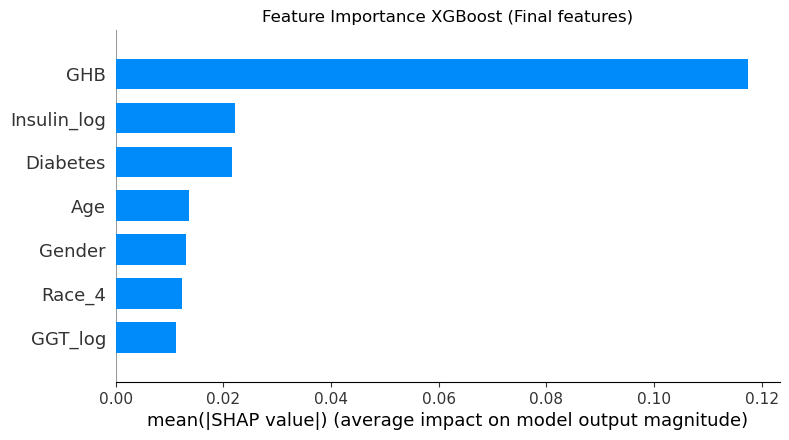

<Figure size 640x480 with 0 Axes>

In [11]:
# Get top 20 features indices frpm SHAP
final_features_idx = np.argsort(np.abs(shap_values.values).mean(axis=0))[-7:]

# Select top 20 features for train, validation and test sets
X_train_reduced = X_train_transformed.iloc[:, final_features_idx]
X_val_reduced = X_val_transformed.iloc[:, final_features_idx]
X_test_reduced = X_test_transformed.iloc[:, final_features_idx]
X_reduced = X_transformed.iloc[:, final_features_idx]

final_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Retrain model on selected features
best_params = random_grid.best_params_
final_model = XGBRegressor(**best_params, random_state=0)
final_model.fit(X_train_reduced, y_train,
                eval_set=[(X_val_reduced, y_val)],
                verbose=0)

# Evaluate results
results_final = evaluate_model(final_model,
                               '3. XGBoost (Final Features)',
                               X_train_reduced, y_train,
                               X_test_reduced, y_test,
                               final_features,
                               table)
print(results_final)

# Analize feature importance with SHAP
explainer = shap.Explainer(final_model, X_train_reduced)
shap_values_final = explainer(X_test_reduced)

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values_final,
                  X_test_reduced,
                  feature_names=final_features,
                  plot_type='bar',
                  show=False)

plt.title('Feature Importance XGBoost (Final features)')
plt.show()
plt.tight_layout()

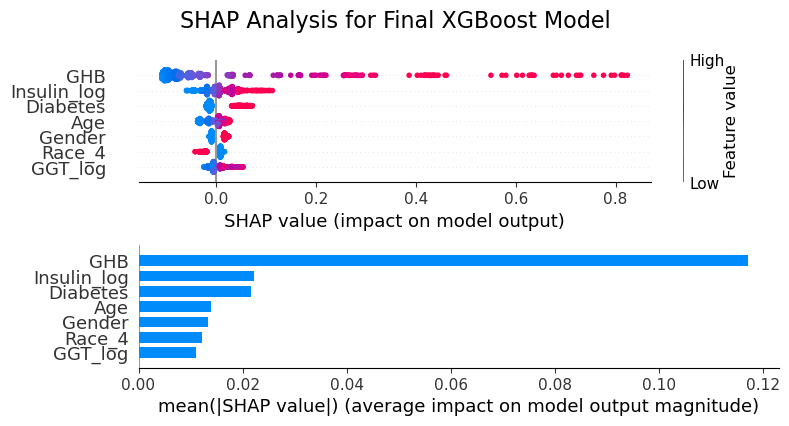

In [293]:
# Save the best model and best features
import joblib

# Save the best model
joblib.dump(final_model, 'final_xgb_model.pkl') 

# Create figure and subplots
fig, ax = plt.subplots(2, figsize=(10,10))

# SHAP baeswarm plot
plt.sca(ax[0])
shap.summary_plot(shap_values_final, X_test_reduced, feature_names=final_features, show=False) 

# SHAP bar plot
plt.sca(ax[1])
shap.summary_plot(shap_values_final, X_test_reduced, feature_names=final_features, plot_type='bar', show=False) 

plt.suptitle('SHAP Analysis for Final XGBoost Model', fontsize=16)

plt.savefig('SHAP_final_model.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

### 3. Feature Engineering

In [12]:
# Create interaction terms

data['Weekend_Flag'] = (data.Sleep_midpoint_weekends - data.Sleep_midpoint_weekdays).astype(int)
data['Circadian_Disruption'] = abs(data.Sleep_midpoint_weekends - data.Sleep_midpoint_weekdays)
data['Sleep_hrs_avg'] = (data.Sleep_hrs_weekdays * 5 + data.Sleep_hrs_weekends * 2) / 7

data['Sleep_hrs_avg_Insulin'] = data.Sleep_hrs_avg * data.Insulin_log
data['Sleep_hrs_Age'] = data.Sleep_hrs_weekdays * data.Age

data['Bedtime_weekdays_Age'] = data.Bedtime_weekdays_hrs_sin * data.Age
data['Disruption_GHB'] = data.Circadian_Disruption * data.GHB
data['Circadian_Disruption_Age'] = data.Circadian_Disruption * data.Age
data['Waist_cm_Jetlag'] = data.Waist_cm * data.Jetlag_hrs

data['SleepMidpoint_Insulin'] = data.Sleep_midpoint_weekends * data.Insulin_log
data['SleepMidpoint_Age'] = data.Sleep_midpoint_weekends * data.Age
data['SocialJetlag_Age'] = data.Jetlag_hrs * data.Age

metabolic_vars = ['BMI', 'Waist_cm', 'HDL', 'GHB', 'CRP_log', 'ALT_log', 'AST_log', 'GGT_log', 'Uric_acid',
                  'Triglycerides_log', 'LDL', 'eGFR', 'ACR', 'Insulin_log',
                  'Bilirubin', 'BP_Systolic', 'BP_Diastolic', 'Fasting_glucose_log', 'BUN', 'LDH', 'Globulin',
                  'Total_protein', 'Cholesterol', 'Creatinine_log',
                 ]

circadian_vars = ['Bedtime_weekdays_hrs_sin', 'Sleep_health', 'Jetlag_hrs', 'Sleep_Apnea_risk',
                  'Sleep_midpoint_weekdays', 'Sleep_midpoint_weekends',
                  'Bedtime_SD', 'Sleep_Duration_SD', 'Sleep_hrs_weekdays', 'Sleep_schedule', 'Sleep_hrs_Category',
                  'Weekend_Flag', 'Circadian_Disruption', 'SleepMidpoint_Insulin', 'Disruption_GHB', 'Bedtime_weekdays_Age', 'Waist_cm_Jetlag',
                  'SleepMidpoint_Age', 'Sleep_hrs_avg', 'Sleep_hrs_avg_Insulin', 'Sleep_hrs_Age', 'SocialJetlag_Age', 'Circadian_Disruption_Age'
                 ]


### Remove highly correlated features

In [13]:
numerical_vars = metabolic_vars + circadian_vars + lifestyle_vars + hormones_vars + nutrients_vars
numerical_data = data[numerical_vars].select_dtypes(include=['number']).drop(columns=['Fasting_glucose_log'])

# Compute correlation matrix
corr_matrix = numerical_data.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find highly correlated pairs
high_corr_pairs = [(col, idx, upper.loc[col, idx]) 
                   for col in upper.columns for idx in upper.index 
                   if upper.loc[col, idx] > 0.85]

# Convert to DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
#print(high_corr_df.sort_values(by='Correlation', ascending=False))

# Features to drop from each pair
features_to_drop = list(set(high_corr_df['Feature 1'].values))
features_to_drop

['Disruption_GHB',
 'Waist_cm_Jetlag',
 'Sleep_hrs_weekdays',
 'Protein',
 'Sleep_health',
 'Niacin',
 'Bedtime_weekdays_hrs_sin',
 'Jetlag_hrs',
 'Energy',
 'LDL',
 'BMI',
 'Circadian_Disruption',
 'Luteinizing_hormone_log',
 'Sleep_midpoint_weekends',
 'ACR']

### 4. Data pipeline

In [14]:
# Select features and target
X = data[control_vars + circadian_vars + metabolic_vars + hormones_vars + nutrients_vars + lifestyle_vars]
X = X.drop(columns=['Fasting_glucose_log'] + features_to_drop)
y = data.Fasting_glucose_log

# Define numerical columns after creating interactions
num_cols = X.select_dtypes(include='number').columns.drop(['Race', 'Gender']).tolist()
#num_cols = X.select_dtypes(include='number').columns.drop(cat_cols_int).tolist()
cat_cols = X.select_dtypes(include='category').columns.tolist() + ['Race']

# Split into train, validation, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=data['Age_Group'], 
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=0, stratify=data.loc[X_train_val.index, 'Age_Group'],
)

# Re-define preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
                                 remainder='passthrough')
# Fit preprocessor on training data
preprocessor.fit(X_train)

# Get feature names out after preprocessing and and align them across transformed train, validation and test sets
feature_names = preprocessor.get_feature_names_out()
feature_names_cleaned = [name.split('__')[-1] for name in feature_names]

# Transform all sets using the fitted preprocessor
X_train_interaction = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=feature_names)
X_val_interaction = pd.DataFrame(preprocessor.transform(X_val), index=X_val.index, columns=feature_names)
X_test_interaction = pd.DataFrame(preprocessor.transform(X_test), index=X_test.index, columns=feature_names)
X_interaction = pd.DataFrame(preprocessor.transform(X), index=X.index, columns=feature_names)


### 5. Retraining model with interaction features

Best parameters:  {'subsample': 0.7, 'reg_lambda': 15, 'reg_alpha': 0.1, 'n_estimators': 1500, 'min_child_weight': 15, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.05, 'colsample_bytree': 0.8}
{'MAE': 0.0847, 'R^2 (Train)': 0.7871, 'R^2 (Test)': 0.7569, 'R^2 (K-Fold validated)': '0.701 ± 0.05', 'Permutation Importance':                               feature  importance_mean  importance_std
17                                GHB         1.020293        0.054982
82                           Diabetes         0.015438        0.003858
25                        Insulin_log         0.013735        0.003887
21                            GGT_log         0.007712        0.002655
0                                 Age         0.007392        0.001312
..                                ...              ...             ...
50                          Vitamin_C        -0.000390        0.000993
18                            CRP_log        -0.000444        0.000508
41                             Sod

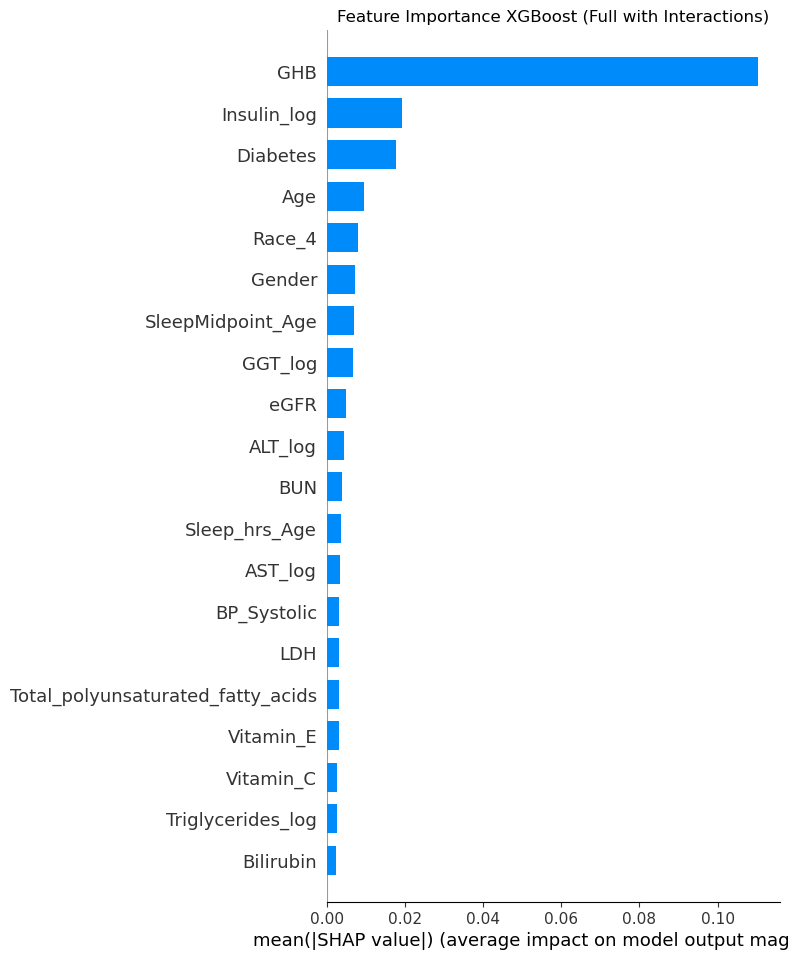

<Figure size 640x480 with 0 Axes>

In [15]:
# Define parameters grid for tuning
param_grid = {
    'n_estimators': [1000, 1200, 1500],
    'learning_rate': [0.01, 0.015, 0.02],
    
    'max_depth': [2, 3],
    'min_child_weight': [10, 12, 15],
    
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],

    'reg_alpha': [0.1, 0.2],
    'reg_lambda': [10, 15, 20],
    'gamma': [0.05, 0.1]
}

# Grid serch
search = RandomizedSearchCV(XGBRegressor(enable_categorical=False, random_state=0),
                            param_grid,
                            n_iter=50,
                            cv=5,
                            scoring='r2',
                            n_jobs=-1,
                            verbose=0)

search.fit(X_train_interaction, y_train)
                
interaction_params = search.best_params_
print('Best parameters: ', best_params)

interaction_model = XGBRegressor(**interaction_params, random_state=0)

# Train the best model
interaction_model.fit(X_train_interaction, y_train,
                      eval_set=[(X_val_interaction, y_val)],
                      verbose=0)

# Evaluate results
results_4 = evaluate_model(interaction_model,
                           '4. XGBoost (Full with Interactions)',
                           X_train_interaction, y_train,
                           X_test_interaction, y_test,
                           feature_names_cleaned,
                           table)
print(results_4)

# Analize feature importance with SHAP
explainer = shap.Explainer(interaction_model, X_train_interaction)
shap_values_inter = explainer(X_val_interaction)

# SHAP summary plot
shap.summary_plot(shap_values_inter,
                  X_val_interaction,
                  feature_names=feature_names_cleaned,
                  plot_type='bar',
                  show=False)

plt.title('Feature Importance XGBoost (Full with Interactions)')
plt.show()
plt.tight_layout()

### 6. Feature Selection 

Choose the seven eight features according to their shap values

{'MAE': 0.0842, 'R^2 (Train)': 0.7543, 'R^2 (Test)': 0.7587, 'R^2 (K-Fold validated)': '0.707 ± 0.047', 'Permutation Importance':              feature  importance_mean  importance_std
7                GHB         1.042229        0.056493
6        Insulin_log         0.023432        0.004525
5           Diabetes         0.018376        0.004373
0            GGT_log         0.014654        0.003621
3             Race_4         0.012195        0.002814
4                Age         0.012173        0.001306
2             Gender         0.006515        0.001838
1  SleepMidpoint_Age         0.003619        0.001655}


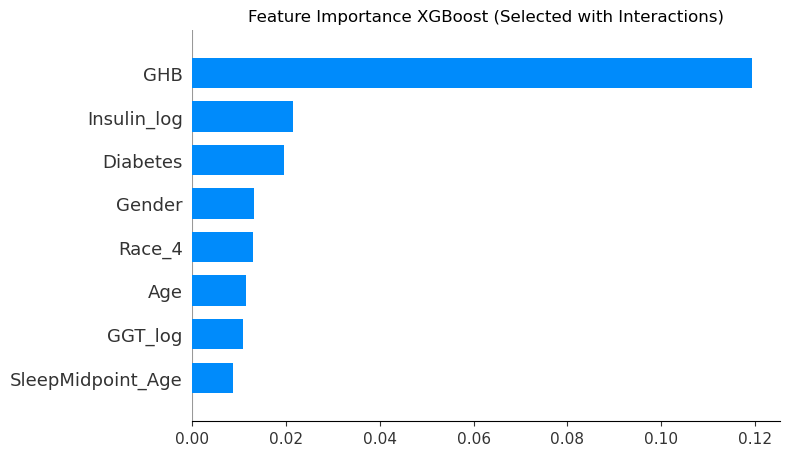

<Figure size 640x480 with 0 Axes>

In [151]:
# Get top 8 features indices frpm SHAP
top_features_idx = np.argsort(np.abs(shap_values_inter.values).mean(axis=0))[-8:]

# Select top 8 features for train, validation and test sets
X_train_reduced = X_train_interaction.iloc[:, top_features_idx]
X_val_reduced = X_val_interaction.iloc[:, top_features_idx]
X_test_reduced = X_test_interaction.iloc[:, top_features_idx]
X_reduced = X_interaction.iloc[:, top_features_idx]

top_features = [col.split('__')[-1] for col in X_train_reduced.columns]

# Retrain model on selected features
selected_model = XGBRegressor(**interaction_params, random_state=0)
selected_model.fit(X_train_reduced, y_train,
                   eval_set=[(X_val_reduced, y_val)],
                   verbose=0)

# Evaluate results
results_reduced = evaluate_model(selected_model,
                                 '5. XGBoost (Selected with Interactions)',
                                 X_train_reduced, y_train,
                                 X_test_reduced, y_test,
                                 top_features,
                                 table)
print(results_reduced)

# Analize feature importance with SHAP
explainer = shap.Explainer(selected_model, X_train_reduced)
shap_values_selected = explainer(X_test_reduced)

# SHAP summary plot
plt.figure(figsize=(6,5))
shap.summary_plot(shap_values_selected,
                  X_test_reduced,
                  feature_names=top_features,
                  plot_type='bar',
                  show=False)

plt.title('Feature Importance XGBoost (Selected with Interactions)')
plt.xlabel('')
plt.show()
plt.tight_layout()



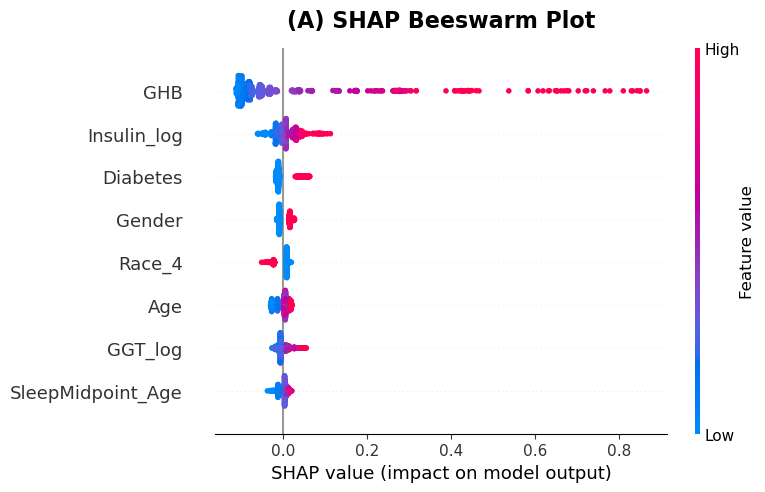

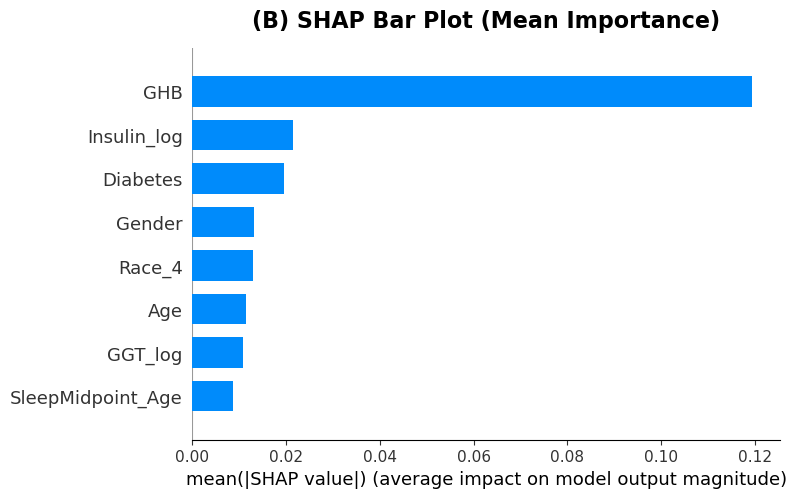

In [152]:
# SHAP Beeswarm Plot
fig, ax = plt.subplots(figsize=(8, 6))

#  SHAP summary plot for beeswarm
shap.summary_plot(shap_values_selected,
                  X_test_reduced,
                  feature_names=top_features,
                  show=False)

# Set title for the beeswarm plot
ax.set_title('(A) SHAP Beeswarm Plot', fontsize=16, pad=15, weight='semibold')

# Save the figure
fig.savefig('SHAP_selected_interactions_model_1.png', dpi=300, bbox_inches='tight')

# SHAP Bar Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Call the shap summary plot for bar plot (with show=False to prevent auto display)
shap.summary_plot(shap_values_selected,
                  X_test_reduced,
                  feature_names=top_features,
                  plot_type='bar',
                  show=False)

# Set title for the bar plot
ax.set_title('(B) SHAP Bar Plot (Mean Importance)', fontsize=16, pad=15, weight='semibold')

# Save the figure
fig.savefig('SHAP_selected_interactions_model_2.png', dpi=300, bbox_inches='tight')

# Show both plots
plt.show()


In [24]:
print(table)

+-----------------------------------------+--------+-------------+------------+-----------------------+----------+
|                  Model                  |  MAE   | R^2 (Train) | R^2 (Test) | R^2 (Cross-validated) | Features |
+-----------------------------------------+--------+-------------+------------+-----------------------+----------+
|      1. ElasticNet (Full Features)      | 0.0919 |    0.6936   |   0.7256   |     0.681 ± 0.044     |    96    |
|        2. XGBoost (Full Features)       | 0.0852 |    0.7838   |   0.7527   |     0.701 ± 0.049     |    96    |
|       3. XGBoost (Final Features)       | 0.0848 |    0.7493   |   0.7566   |     0.707 ± 0.046     |    7     |
|   4. XGBoost (Full with Interactions)   | 0.0847 |    0.7871   |   0.7569   |      0.701 ± 0.05     |   101    |
| 5. XGBoost (Selected with Interactions) | 0.0842 |    0.7543   |   0.7587   |     0.707 ± 0.047     |    8     |
+-----------------------------------------+--------+-------------+------------+-

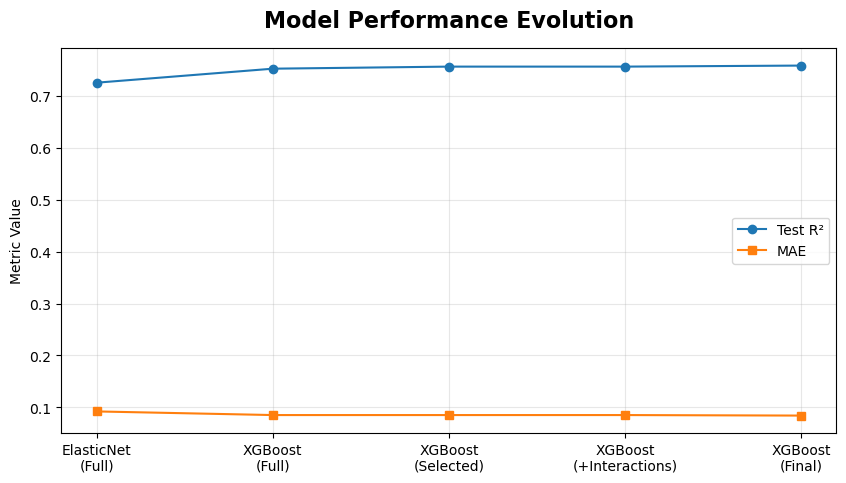

In [157]:
# Create performance evolution plot
plt.figure(figsize=(10,5))
plt.plot([1,2,3,4,5], [0.726, 0.753, 0.757, 0.757, 0.759], 
        marker='o', label='Test R²')
plt.plot([1,2,3,4,5], [0.092, 0.085, 0.085, 0.085, 0.084], 
        marker='s', label='MAE')
plt.xticks(ticks=[1,2,3,4,5], 
          labels=['ElasticNet\n(Full)', 'XGBoost\n(Full)', 
                  'XGBoost\n(Selected)', 'XGBoost\n(+Interactions)', 
                  'XGBoost\n(Final)'])
plt.title('Model Performance Evolution', fontsize=16, pad=15, weight='semibold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('model_performance_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

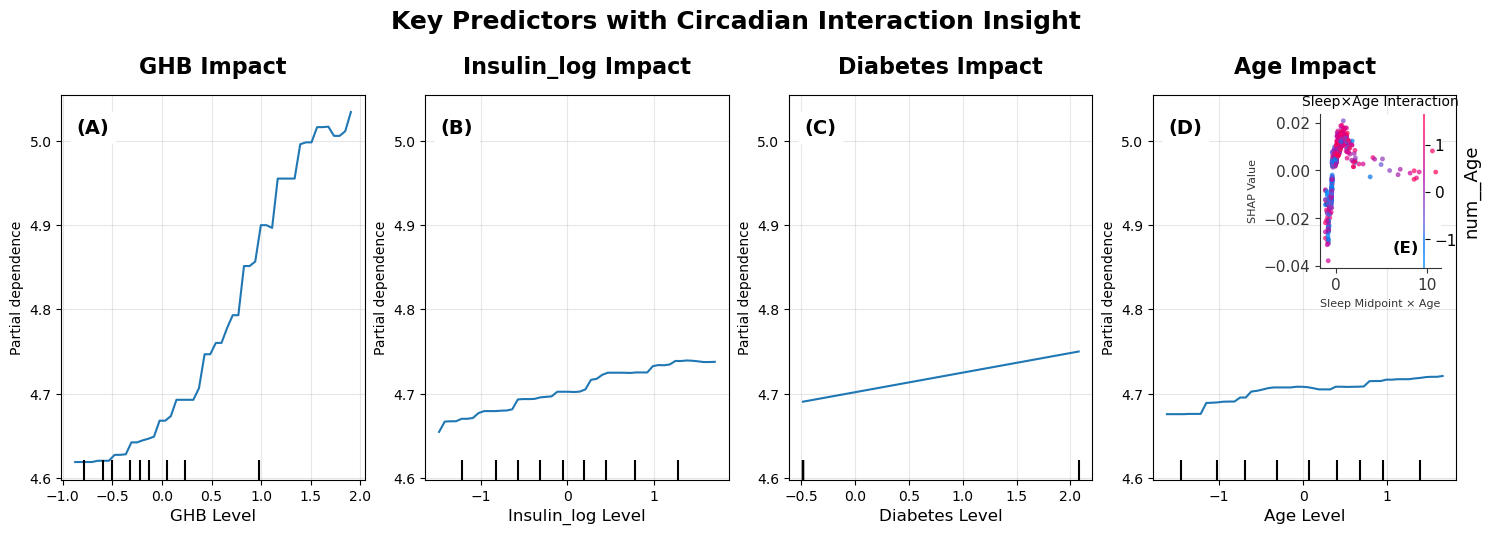

In [156]:
from sklearn.inspection import PartialDependenceDisplay

# Define top features for PDP
main_features = ['num__GHB', 'num__Insulin_log', 'num__Diabetes', 'num__Age']
sleep_feature = 'num__SleepMidpoint_Age'

# Create figure with 3 subplots 
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Generate main PDPs
pdp_display = PartialDependenceDisplay.from_estimator(
    selected_model, 
    X_train_reduced, 
    features=main_features,
    grid_resolution=50,
    kind='average',
    ax=axes
)

# Add sleep interaction bonus using feature index
sleep_idx = X_test_reduced.columns.get_loc(sleep_feature)
age_idx = X_test_reduced.columns.get_loc('num__Age')

axins = axes[3].inset_axes([0.55, 0.55, 0.4, 0.4])
shap.dependence_plot(
    sleep_idx,  
    shap_values_selected.values,
    X_test_reduced.values,
    feature_names=X_test_reduced.columns.tolist(),
    interaction_index=age_idx,
    ax=axins,
    show=False,
    dot_size=12,
    alpha=0.7
)

# Customize plots
for i, ax in enumerate(axes):
    clean_name = main_features[i].split('__')[-1]
    ax.set_title(f'{clean_name} Impact', fontsize=16, pad=15, weight='semibold')
    ax.set_xlabel(f'{clean_name} Level', fontsize=12)
    ax.grid(alpha=0.3)


axins.set_title('Sleep×Age Interaction', fontsize=10)
axins.set_xlabel('Sleep Midpoint × Age', fontsize=8)
axins.set_ylabel('SHAP Value', fontsize=8)

# Labeling plots (A-D)
for i, ax in enumerate(axes):
    ax.annotate(f'({chr(65+i)})',  # 65 = ASCII for 'A'
                xy=(0.05, 0.9), 
                xycoords='axes fraction',
                fontsize=14, weight='bold',
                backgroundcolor='white')

# Add 'E' to the inset
axins.annotate('(E)', 
              xy=(0.60, 0.10), 
              xycoords='axes fraction',
              fontsize=12, weight='bold',
              backgroundcolor='white')

# Save figure
plt.savefig('PDP_labeled.png', dpi=300, bbox_inches='tight')

plt.suptitle('Key Predictors with Circadian Interaction Insight',
             y=1.05, fontsize=18, weight='bold')
plt.savefig('final_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

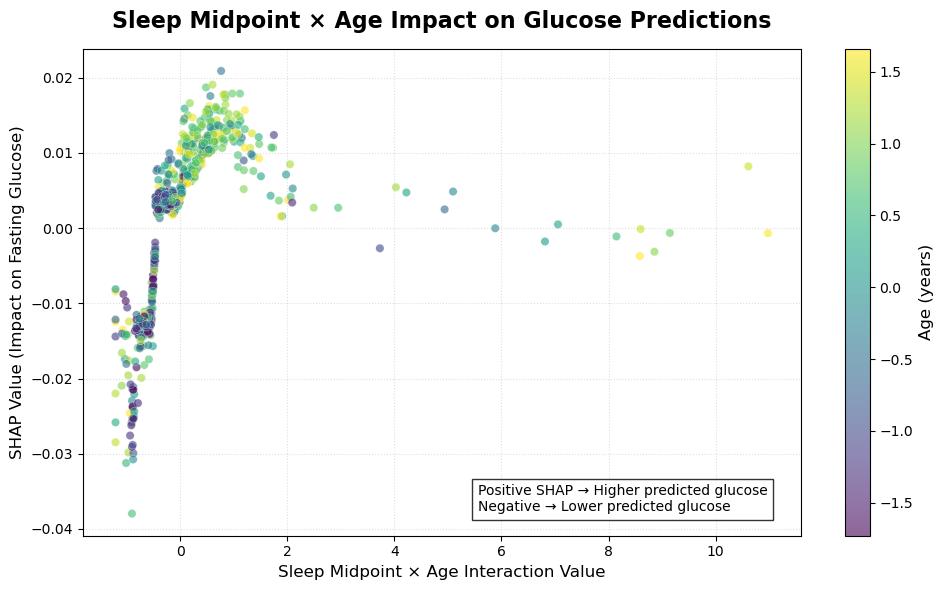

In [153]:
plt.figure(figsize=(10, 6))

# Get feature values and SHAP values
feature_values = X_test_reduced['num__SleepMidpoint_Age']
shap_vals = shap_values_selected.values[:, X_test_reduced.columns.get_loc('num__SleepMidpoint_Age')]
age_values = X_test_reduced['num__Age']

# Create scatter plot with color mapping
scatter = plt.scatter(feature_values, shap_vals, 
                     c=age_values, 
                     cmap='viridis', 
                     alpha=0.6,
                     edgecolors='w',
                     linewidth=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Age (years)', fontsize=12)

# Add labels and styling
plt.title('Sleep Midpoint × Age Impact on Glucose Predictions', fontsize=16, pad=15, weight='semibold')
plt.xlabel('Sleep Midpoint × Age Interaction Value', fontsize=12)
plt.ylabel('SHAP Value (Impact on Fasting Glucose)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.4)

# Add interpretation text
plt.text(0.55, 0.05, 
        'Positive SHAP → Higher predicted glucose\nNegative → Lower predicted glucose',
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('sleep_age_interaction.png', dpi=300, bbox_inches='tight')
plt.show()